In [1]:
!python --version

Python 3.9.16


# Практическая работа по распознаванию речи #4: <br> Поиск наилучшей гипотезы распознавания
Задача распознавания речи состоит в поиске наиболее вероятной словной гипотезы по имеющемуся звуковому сигналу. Используя теорему Байеса, формулировку задачи можно написать так:
$$ W^* = \underset{W}{argmax} {P(W|O)} =  \underset{W}{argmax} \sum_i^N{(\log{P(O|w_i)} + \log{P(w_i|w_{i-1}, w_{i-2},..))}}$$
Где: 
* $O$ - звук
* $W$ - словная гипотеза распознавания 
* $W^*$ - лучшая гипотеза распознавания
* $P(W|O)$ - вероятность гипотезы распознавания при условии наблюдения $O$
* $N$ - количество слов в гипотезе
* $w_i$ - i'ое слово в гипотезе
* $P(O|w_i)$ - акустическое правдоподобие слова (выводится из предсказания акустической моделью)
* $P(w_i|w_{i-1}, w_{i-2},..)$ - языковая вероятность слова при условии контекста (предсказывается языковой моделью)


В прошлых лабораторных работах были изучены акустическая и языковая модели. Акустическая модель предсказывает вероятность принадлежности кадра некоему акустическому классу (фонеме). Языковая модель предсказывает априорную вероятность последовательности слов. Пришло время разобраться, как соединить эти части в одну систему и получить итоговый результат распознавания. 





Основная часть (14 баллов) данной практической работы состоит из двух частей: 
* знакомство с Weighted Finite State Transducer (WFST)
* WFST декодинг в ASR системе

Дополнительная часть - тюнинг параметров (2 балла)

## Полезные ссылки: 
* Наиболее популярная библиотека WFST - [OpenFst](https://www.openfst.org/twiki/bin/view/FST/WebHome)
* Библиотека для визуализации - [graphviz](https://graphviz.readthedocs.io/en/stable/manual.html)
* Алгоритм обхода графа в ширину - [BFS](https://neerc.ifmo.ru/wiki/index.php?title=%D0%9E%D0%B1%D1%85%D0%BE%D0%B4_%D0%B2_%D1%88%D0%B8%D1%80%D0%B8%D0%BD%D1%83)

In [2]:
!python --version 

Python 3.9.16


In [3]:
#!pip install graphviz kenlm kaldiio jiwer

In [4]:
import numpy as np
import time
import os
import abc

from typing import List, Dict, Union, Set, Any, Optional, Tuple
from tqdm.auto import tqdm
from collections import defaultdict
from pathlib import Path
from dataclasses import dataclass

import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display

import graphviz
import kenlm 
import jiwer
from kaldiio import ReadHelper

# 1. Weighted Finite State Transducer (WFST)



Из определения в wiki [Weighted Finite State Transducer (Взвешенный конечный автомат с выходом)](https://en.wikipedia.org/wiki/Finite-state_transducer) следует, что главная задача FST - это переводить символы из входного алфавита в соответствующие им символы из выходного алфавита. Например, с помощью FST можно перевести последовательность фонем в последовательность слов. Конечный автомат будет менять свое состояние при обработке последовательности входных символов (фонем). Когда он соберет из входных фонем корректную транскрипцию слова, то выдаст это слово на выход. 

Однако не всегда можно однозначно перевести последовательность фонем в слова (некоторые слова произносятся одинаково, а пишутся по-разному), поэтому для распознавания речи надо использовать не простой FST, а взвешенный. WFST позволяет не только перевести входные символы в выходные, но и оценить вес такого перевода. Чем больше вес, тем хуже гипотеза.  

Напишем собственную реализацию WFST.


### AbstractWFST
AbstractWFST -- это базовый интерфейс нашего WFST. В нем заданы основные методы, через которые мы будем работать с wfst  
* get_start - возвращаяет стартовое состояние конечного автомата.
* final_score - вес завершения работы в данном состоянии. В некоторых состояниях завершить обработку невозможно, в таких случаях final weight  будет равен бесконечности.
*  transduce - совершает переход из текущего состояния в следующее, соответствующее переходу по символу ilabel. Возвращает выходной символ, вес перехода и следующее состояние.  




 

In [5]:
class AbstractWFST(abc.ABC):
    def __init__(self):
        pass
    
    @abc.abstractmethod
    def get_start(self) -> Any:
        """Return start state"""
    
    @abc.abstractmethod
    def final_score(self, state: Any) -> float:
        """is the state final? If true return negative log likelihood of the finalization. otherwise return inf"""
           
    @abc.abstractmethod
    def transduce(self, state: Any, ilabel: str) -> Tuple[Tuple[str, float, Any]]:
        """Transduce ilabel to olabel. 
        return all available olabels for this state and ilabel pair
        return type - ((olabel1, weight1, nextstate1), 
                       ((olabel1, weight1, nextstate1), 
                       ...)"""

### SymbolsMap

Для того, чтобы задать WFST, первым делом нам понадобятся таблицы входных и выходных символов. Для задания таблиц будем использовать класс SymbolsMap. Данный класс служит для маппинга символов на индексы и обратно. 

In [6]:
class SymbolsMap:
    def __init__(self, id2symbol: Optional[Dict[int, str]] = None, symbol2id: Optional[Dict[str, int]] = None):
        assert id2symbol is not None or symbol2id is not None, f"One id2symbol or symbol2id must be not None"
        assert id2symbol is None or symbol2id is None, f"Only one One id2symbol or symbol2id can be not None"
        if id2symbol is None:
            self.id2symbol = {i:s for s,i in symbol2id.items()}
        elif isinstance(id2symbol, dict):
            self.id2symbol = id2symbol
        elif isinstance(id2symbol, list):
            self.id2symbol = {i:s for i, s in enumerate(id2symbol)}
        else:
            raise RuntimeError(f"unknown type {type(id2symbol)=}")
            
        if symbol2id is None:
            self.symbol2id = {s:i for i, s in self.id2symbol.items()}
        else:
            self.symbol2id = symbol2id   
                
        assert self.id2symbol[0] == '<eps>', f"wrong {self.id2symbol}"

    def get_id(self, symbol: str):
        return self.symbol2id[symbol]
        
    def get_symbol(self, id: int):
        return self.id2symbol[id] 
    
    @classmethod
    def from_file(cls, fname):
        """read symbols table from file
        format: 
            word id
            word2 id2
            ...
        """
        with open(fname) as f:
            s2i = {s:int(i) for s, i in map(str.split, f.readlines())}
        return cls(symbol2id=s2i)

### Arc и ILabelIndexedArcs
Переходы внутри FST будем описывать с помощью класса, инкапсулирующего информацию о входном/выходном индексе символа, весе перехода и следующем состоянии FST. Поскольку дуги мы будем хранить отдельно для каждого состояния, информация о текущем состоянии в дуге не нужна. 

Для быстрого выбора нужной дуги создадим специальную коллекцию ILabelIndexedArcs. Данная коллекция хранит дуги таким образом, чтобы выбор дуги по входному символу осуществлялся за O(1). 


In [7]:
@dataclass
class Arc:
    """Arc in WFST"""
    ilabel: int
    olabel: int
    weight: float
    nextstate: Any

class ILabelIndexedArcs:
    def __init__(self, arcs: Optional[List[Arc]] = None):
        self.ilabel2arclist = defaultdict(list)
        if arcs is not None:
            for arc in arcs:
                self.add_arc(arc)

    def add_arc(self, arc: Arc):
        self.ilabel2arclist[arc.ilabel].append(arc)

    def get_arcs_by_ilabel(self, ilabel: int):
        return self.ilabel2arclist[ilabel]

    def arcs(self) -> List[Arc]:
        """Return all arcs"""
        all_arcs = []
        # TODO
        # реализуйте функцию, которая возвращает все дуги, хранящиеся в данной коллекции
        for ilabel in self.ilabel2arclist:
            arcs = self.ilabel2arclist[ilabel] # TODO: Or extend ?
            all_arcs.extend(arcs)
        return all_arcs 

    def __str__(self):
        return "ILabelIndexedArcs([" + ", ".join(f"{a}" for a in self.arcs()) + "])"
        
    def __repr__(self):
        return str(self)

In [8]:
# test 1.a
def test_ILabelIndexedArcs():
    # проверка что arcs работает правильно 
    arcs = [Arc(i, -i, i/100, i+100) for i in range(10)]
    c = ILabelIndexedArcs(arcs)
    arcs2 = c.arcs()
    
    assert len(arcs) == len(arcs2), f"{len(arcs)=}, {len(arcs2)=}\n{arcs} != {c.arcs()}"
    for a in arcs2:
        assert a in arcs, f"{a=} not in {arcs=}"
    print('Test 1.a passed')
test_ILabelIndexedArcs()    

Test 1.a passed


### WFST 
Все готово для создания взвешенного конечного автомата. Класс WFST состоит из таблицы входных и выходных символов, списка состояний и коллекции дуг для каждого, а также множества финальных состояний. 

In [9]:
class WFST(AbstractWFST):
    def __init__(self, 
                 isymbols: Optional[SymbolsMap] = None, 
                 osymbols: Optional[SymbolsMap] = None):
        self.start = 0
        self.states = [0]
        # состояния, в которых может завершиться декодирование без какого либо штрафа 
        self.final_states = set() 
        self.isymbols = isymbols
        self.osymbols = osymbols
        self.state2arcs = defaultdict(ILabelIndexedArcs)

    def get_start(self):
        """return start state"""
        return self.start
        
    def final_score(self, state_id: int):
        """return the weight of decoding completion in state_id"""
        # TODO 
        # верните вес завершения декодирования в state_id 
        if state_id in self.final_states:
            # weight = self.state2arcs[state_id] #.arcs()[-1].weight #!!!!! #TODO
            return 0
        return float('inf')
       
    def transduce(self, state, ilabel: str) -> Tuple[Tuple[str, float, int]]:
        """transitions wfst to next state by 'ilabel' input symbol, except when the input symbol is <eps>.
        Returns all possible output results as a tuple of triples (olabel, weight, nextstate)."""
        assert self.isymbols is not None and self.osymbols is not None, f"Cannot transduce w/o both symbols tables" 
        if ilabel == '<eps>':
            # skip <eps> input
            return ((ilabel, 0, state), )
        label_id = self.isymbols.get_id(ilabel)
        # TODO 
        # верните все возможные результаты перехода из текущего состояния по входу ilabel
        # результат должен выглядеть так: tuple(("слово", 0.1, 2), ("другоеслово", 10, 4), ...)
        result = tuple()
        for arc in self.state2arcs[state].arcs():
            if label_id == arc.ilabel:
                result += ((self.osymbols.get_symbol(arc.olabel), arc.weight, arc.nextstate), )
        return result
    
    def set_final(self, state: int):
        """sets the final weight for the state to zero"""
        # TODO добавьте возможность завершать декодирование в state
        self.final_states.add(state)
        
    def new_state(self):
        """Create new state id and return it"""
        # TODO 
        # добавьте в конечный автомат новое состояние и верните его id 
        state_id = self.states[-1] + 1 
        self.states.append(state_id) 
        return state_id 
    
    def add_arc(self, state_from: int, arc: Arc):
        """adds a new arc for this state"""
        # TODO 
        # добавьте в конечный автомат новых переход arc, выходящий из state_from 
        self.state2arcs[state_from].add_arc(arc)
    
    def to_dot(self):
        """Visualize the WFST""" 
        dot = graphviz.Digraph()
        for s in self.states:
            dot.node(str(s))
        for state_from, arcs_container in self.state2arcs.items():
            for arc in arcs_container.arcs():
                il = self.isymbols.get_symbol(arc.ilabel) if self.isymbols is not None else arc.ilabel
                ol = self.osymbols.get_symbol(arc.olabel) if self.osymbols is not None else arc.olabel
                dot.edge(str(state_from), str(arc.nextstate), label=f"{il}:{ol}:{arc.weight:.2f}")
        return dot
    

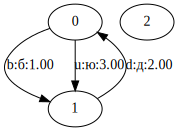

test 1.b passed


In [10]:
# test 1.b
def test_WFST():
    en_l = SymbolsMap(id2symbol=['<eps>', 'b', 'd', 'u'])
    ru_l = SymbolsMap(id2symbol=['<eps>', 'ю', 'б', 'д'])
    
    # create first transducer
    en2ru = WFST(isymbols=en_l, osymbols=ru_l)
    # new_state
    en2ru_final = en2ru.new_state()
    assert en2ru_final == 1 , f'start - zero, next state - one, next - two ...'
    assert en2ru.new_state() == 2, f'start - zero, next state - one, next - two ...'
    en2ru.set_final(en2ru_final)
    en2ru.add_arc(en2ru.get_start(), Arc(1, 2, 1.0, en2ru_final))
    en2ru.add_arc(en2ru_final, Arc(2, 3, 2.0, en2ru.get_start()))
    en2ru.add_arc(en2ru.get_start(), Arc(3, 1, 3.0, en2ru_final))
    # you can use this line to visualize
    display.display(en2ru.to_dot())

    # final_score # set_final
    assert en2ru.final_score(en2ru.get_start()) == float('inf')
    assert en2ru.final_score(en2ru_final) == 0
    en2ru.set_final(en2ru.get_start())
    assert en2ru.final_score(en2ru_final) == en2ru.final_score(en2ru.get_start()) == 0

    # transduce # add_arc
    assert en2ru.transduce(en2ru.get_start(), 'd') == tuple() , "Cannot transduce 'd' from start state. output must be zero len tuple"
    assert en2ru.transduce(en2ru.get_start(), 'b') == (('б', 1.0, en2ru_final), ) , "Arc(1, 2, 1.0, en2ru_final)"
    assert en2ru.transduce(en2ru.get_start(), 'u') == (('ю', 3.0, en2ru_final), ) , "Arc(3, 1, 3.0, en2ru_final)"
    assert en2ru.transduce(en2ru_final, 'd') == (('д', 2.0, en2ru.get_start()), ) , "Arc(2, 3, 2.0, en2ru.get_start())"
    
    print('test 1.b passed')
test_WFST()

## wfst композиция 


Над WFST определен большой набор различных операций, реализация большинства из которых является сложной алгоритмической задачей. Важной для распознавания речи операцией является [композиция](https://www.openfst.org/twiki/bin/view/FST/ComposeDoc) набора различных wfst. 

OpenFST дает следующее определение композиции:
 
"This operation computes the composition of two transducers. If A transduces string x to y with weight a and B transduces y to z with weight b, then their composition transduces string x to z with weight a ⊗ b."

Другими словами, результатом композиции является wfst, применение которого к входной последовательности даст такой же результат, как и последовательное применение композируемых wfst. 

Хорошим примером композиции различных WFST является граф распознавания в гибридных системах распознавания речи. Такой граф является результатом композиции четырех wfst:
* H - Hidden Markov Model wfst (переводит акустические классы, предсказанные с помощью AM, в трифоны)
* С - Context-dependency transducer (переводит трифоны (тройки (leftcontext,phone,rightcontext)) в фонемы)
* L - lexicon (переводит фонемы в слова)
* G - ngram lm (оценивает вероятность последовательностей слов)
 
Итого граф распознавания можно выразить с помощью следующей формулы:
$$ HCLG = H⊗C⊗L⊗G $$ 
где ⊗ - оператор композиции двух wfst. Подробнее про граф распознавания можно почитать в [документации к фреймворку kaldi](https://kaldi-asr.org/doc/graph.html)


Композиция позволяет объединить много обработчиков в один большой граф, что несомненно является большим плюсом для построения продакшн решений. Но у такого подхода есть и минусы - процесс подготовки графа очень сложен и требует множества оптимизаций. Это усложняет любые эксперименты и модификации системы. В данной работе мы не будем реализовывать честную композицию графа, а будем считать композицию "On the Fly". То есть сделаем обертку, реализующую интерфейс AbstractWFST, состоянием которой будет Tuple состояний всех композируемых wfst, а метод transduce будет последовательно проходить через эти wfst. Тем самым, по определению композиции, наш класс будет эквивалентен честной композиции.  



In [11]:
class OnTheFlyCompose(AbstractWFST):
    def __init__(self, wfsts: List[AbstractWFST]):
        # !!!Attention!!! wfsts - это лист AbstractWFST, а не WFST. 
        # Для работы с wfsts истользуйте только методы из AbstractWFST
        self.wfsts = wfsts

    def get_start(self):
        return tuple(fst.get_start() for fst in self.wfsts)

    def final_score(self, state: Tuple[Any]):
        assert len(state) == len(self.wfsts)
        # TODO 
        # посчитайте финальный скор для state
        # результат композиции может завершить обработку только в тех стейтах, где все wfsts будут в финальных состояниях
        scores = []
        for st, wfst in zip(state, self.wfsts):
            scores.append(wfst.final_score(st))
        return 0 if all([score == 0 for score in scores]) else float("inf")
    
    def _transduce(self, state: Tuple[Any], ilabel: str) -> List[Tuple[List[str], float, List[int]]]:
        assert len(self.wfsts) == len(state)
        # Найдите все возможные гипотезы перевода ilabel с помощью композиции всех self.wfsts
        # Последовательно пройдите через все self.wfsts, расширяя список гипотез и дополняя гипотезы новыми слоями 
        # Верните результат в виде списка гипотез. 
        # Каждая гипотеза содержит три элемента: 
        #   0. список символов со ВСЕХ прошедших слоев композиции 
        #   1. суммарный вес гипотезы 
        #   2. список состояний, в которые перешли self.wfsts 

        # Одна стартовая гипотеза. Корень для всех гипотез.
        # Еще никакой wfst не применен, символ только ilabel, вес стартовый, стейтов еще нет. 
        hyps_per_layer = [([ilabel], 0, [])]
        for fst, s in zip(self.wfsts, state):
            new_hyps = []
            # TODO 
            # примените fst.transduce ко всем гипотезам из hyps_per_layer
            # постепенно разветвляя их и сохраняя в new_hyp
            # на вход подайте выход последнего из уже обработаных слоев 

            for hyp in hyps_per_layer:
                ilabel = hyp[0][-1]
                for trans in fst.transduce(s, ilabel):
                    # new_hyps.append(( # Тут был баг
                    #     hyps_per_layer[0][0]  + [trans[0]],
                    #     hyps_per_layer[0][1]  +   trans[1],
                    #     hyps_per_layer[0][2]  + [trans[2]],
                    # ))
                    new_hyps.append((
                        hyp[0]  + [trans[0]],
                        hyp[1]  +   trans[1],
                        hyp[2]  + [trans[2]],
                    ))
            
            hyps_per_layer = new_hyps
            
        return hyps_per_layer

    def transduce(self, state: Tuple[Any], ilabel: str):
        hyps_per_layer = self._transduce(state, ilabel)
        # выходной символ transduce в композиции - это выходной символ самого последнего wfst 
        return tuple((ls[-1], w, tuple(ss)) for ls, w, ss in hyps_per_layer)
    

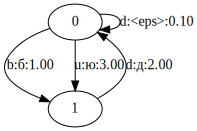

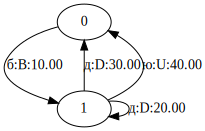

Test 1.c passed


In [12]:
def test_OnTheFlyCompose():
    en_l = SymbolsMap(id2symbol=['<eps>', 'b', 'd', 'u'])
    ru_l = SymbolsMap(id2symbol=['<eps>', 'ю', 'д', 'б'])
    en_U = SymbolsMap(id2symbol=['<eps>', 'B', 'D', 'U'])
    ru_U = SymbolsMap(id2symbol=['<eps>', 'Ю', 'Д', 'Б'])
    
    # create first transducer
    en2ru = WFST(isymbols=en_l, osymbols=ru_l)
    en2ru_final = en2ru.new_state()
    en2ru.set_final(en2ru_final)
    en2ru.add_arc(en2ru.get_start(), Arc(1, 3, 1.0, en2ru_final))
    en2ru.add_arc(en2ru_final, Arc(2, 2, 2.0, en2ru.get_start()))
    en2ru.add_arc(en2ru.get_start(), Arc(2, 0, 0.1, en2ru.get_start()))
    en2ru.add_arc(en2ru.get_start(), Arc(3, 1, 3.0, en2ru_final))
    # you can use this line to visualize
    display.display(en2ru.to_dot())

    # OnTheFlyCompose одного fst работает так же как и этот fst
    comp = OnTheFlyCompose([en2ru])
    for s in (0, 1):
        for il in 'bdu':
            hyps1 = en2ru.transduce(s, il)
            hyps2 = comp.transduce((s,), il)
            for h in hyps2:
                # only one state
                assert len(h[2]) == 1, f"{hyps2=}"
            hyps2_flatten = tuple((l, w, ss[0]) for l,w,ss in hyps2)
            assert hyps1 == hyps2_flatten, f"{hyps1=} {hyps2_flatten=}"
        
        scores = [float('inf'), 0]
        your_score = comp.final_score((s,))
        assert your_score == scores[s], f"Your score = {your_score}, correct = {scores[s]}"

    # create second transducer
    ru2en = WFST(isymbols=ru_l, osymbols=en_U)
    ru2en_final = ru2en.new_state()
    ru2en.set_final(ru2en_final)
    ru2en.add_arc(ru2en.get_start(), Arc(3, 1, 10.0, ru2en_final))
    ru2en.add_arc(ru2en_final, Arc(2, 2, 20.0, ru2en_final))
    ru2en.add_arc(ru2en_final, Arc(2, 2, 30.0, ru2en.get_start()))
    ru2en.add_arc(ru2en_final, Arc(1, 3, 40.0, ru2en.get_start()))
    
    # you can use this line to visualize
    display.display(ru2en.to_dot())

    # композиция двух работает как последовательное применение каждого 
    comp = OnTheFlyCompose([en2ru, ru2en])
    hyps = comp.transduce((0, 0), 'b')
    assert hyps == (('B', 11.0, (1, 1)), ) , f"{hyps =}"
    hyps = comp.transduce((1, 1), 'd')
    assert hyps == (('D', 22.0, (0, 1)), ('D', 32.0, (0, 0))) , f"{hyps =}"
    hyps = comp.transduce((0, 1), 'd')
    assert hyps == (('<eps>', 0.1, (0, 1)), ) , f"{hyps =}"
    # Проверка правильности расчетов final_score
    your_score = comp.final_score((0, 0))
    assert your_score == float('inf'), f"Your score = {your_score}, correct = {float('inf')}"
    your_score = comp.final_score((0, 1))
    assert your_score == float('inf'), f"Your score = {your_score}, correct = {float('inf')}"
    your_score = comp.final_score((1, 0))
    assert your_score == float('inf'), f"Your score = {your_score}, correct = {float('inf')}"
    your_score = comp.final_score((1, 1))
    assert your_score == 0, f"Your score = {your_score}, correct = {0}"
    print('Test 1.c passed')
    
    
test_OnTheFlyCompose()

# 2. WFST декодинг в ASR системе
Отлично, код WFST готов, теперь необходимо собрать граф распознавания и написать поиск наилучшей гипотезы 




In [13]:
# Сначала подготовим нужные нам таблицы символов
AM_PHONES = {0: 'pau', 1: 'aa', 2: 'ae', 3: 'ah', 4: 'ao', 5: 'aw', 6: 'ax', 7: 'ax-h', 8: 'axr', 9: 'ay', 10: 'b', 
             11: 'bcl', 12: 'ch', 13: 'd', 14: 'dcl', 15: 'dh', 16: 'dx', 17: 'eh', 18: 'el', 19: 'em', 20: 'en', 
             21: 'eng', 22: 'er', 23: 'ey', 24: 'f', 25: 'g', 26: 'gcl', 27: 'hh', 28: 'hv', 29: 'ih', 30: 'ix', 
             31: 'iy', 32: 'jh', 33: 'k', 34: 'kcl', 35: 'l', 36: 'm', 37: 'n', 38: 'ng', 39: 'nx', 40: 'ow', 
             41: 'oy', 42: 'p', 43: 'pcl', 44: 'q', 45: 'r', 46: 's', 47: 'sh', 48: 't', 49: 'tcl', 50: 'th', 
             51: 'uh', 52: 'uw', 53: 'ux', 54: 'v', 55: 'w', 56: 'y', 57: 'z', 58: 'zh'}

# таблица фонем для wfst 
def create_phones_txt(fname='exp/phones.txt'):
    fname = Path(fname) 
    fname.parent.mkdir(exist_ok=True, parents=True)
    with open(fname, 'w') as f:
        f.write('<eps> 0\n') # !! shift all ids by one !! 
        for i, p in sorted(AM_PHONES.items()):
            f.write(f'{p} {i+1}\n')
create_phones_txt()


In [14]:
# Загрузим подготовленный лексикон из датасета 
def load_lexicon_file(fname='timit/TIMITDIC.TXT', words_limit=-1):
    """generator running through the 'fname' phonetic dictionary 
    yield (word: str, phones: List[str])"""
    num = 0
    with open(fname) as f:
        for line in map(str.strip, f.readlines()):
            if line.startswith(';'):
                continue
            word, trans, _ = line.split('/')
            # remove ~adj suffix 
            word = word.split('~')[0].strip() 
            # remove stress factor
            trans = [t[:-1] if t[-1].isdigit() else t for t in trans.split()]
            yield word, trans
            num += 1
            if words_limit == num:
                break

In [15]:
# подготовим таблицу слов
def create_words_txt(fname='exp/words.txt', dic_fname='../../asr_itmo_practice/timit/TIMITDIC.TXT'):
    fname = Path(fname)
    fname.parent.mkdir(exist_ok=True, parents=True)
    words = ['<eps>'] + [w for w, _ in sorted(load_lexicon_file(dic_fname))] + ['<s>', '</s>']
    with open(fname, 'w') as f:
        f.write(''.join(f'{w} {i}\n' for i, w in enumerate(words)))
create_words_txt()

# H transducer

Создадим первый wfst. 

В гибридном пайплайне задача первых двух wfst (H и C) - это перевести предсказанные с помощью акустической модели классы в последовательность фонем. В нашем случае все значительно легче, так как АМ (из работы №3) уже учится предсказывать фонемы. H.wfst остается только преобразовать вероятности, которые оценивает AM, в правдоподобие, добавив к скорам фонем их априорную вероятность.


Необходимый нам для декодирования граф H.wfst состоит из одного состояния и N петель, где N - это количество фонем. Каждая петля соответствует определенной фонеме и хранит логарифм ее априорной вероятности.

![image](resources/lab4/H_example.svg)

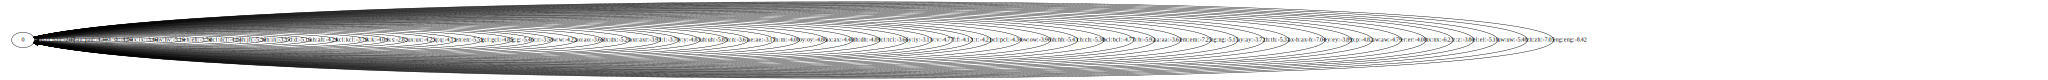

In [16]:
def create_h_wfst(prior_file='resources/lab4/phone.priors', phones_fname='exp/phones.txt'):
    """Create H.wfst. just transduce AM probability to AM likelihood (Bayes theorem)
    """
    symbols = SymbolsMap.from_file(phones_fname)
    h_fst = WFST(isymbols=symbols, osymbols=symbols)
    s = h_fst.get_start()
    h_fst.set_final(s)
    with open(prior_file) as f:
        for ph, prior in map(str.split, f.readlines()):
            log_prior = np.log(float(prior))
            ph_id = symbols.get_id(ph)
            h_fst.add_arc(s, Arc(ph_id, ph_id, log_prior, s))
    return h_fst
create_h_wfst().to_dot()

# L transducer

Lwfst - это WFST, который преобразует входные последовательности фонем в слова.

Например, `pau pau ae1 ae1 ae1 ae1 ae1 ae1 r pau pau pau y y y y eh1 s s s pau` -> `air yes`

Чтобы контролировать количество слов в выходной гипотезе, в L добавляется два веса: 
* word_insertion_penalty - штраф за добавление слова 
* stay_in_silence_penalty - штраф за пропуск паузы (фонемы pau)

Пример Lwfst, построенного для слов `'em` `-knacks`, с параметрами word_insertion_penalty=0.5, stay_in_silence_penalty=0.01

![image](./resources/lab4/L_example.svg)

Фонема паузы pau обрабатывается особым способом: L.fst может пропускать ее, не генерируя ничего на выходе. Также у окончания каждой транскрипции слова есть две отдельные дуги, возвращающие FST в стартовое состояние. Это нужно для того, чтобы была возможность как обработать подряд идущие дупликаты последней фонемы на конце слова, так и перейти в стартовое состояние всего по одной финальной фонеме. 

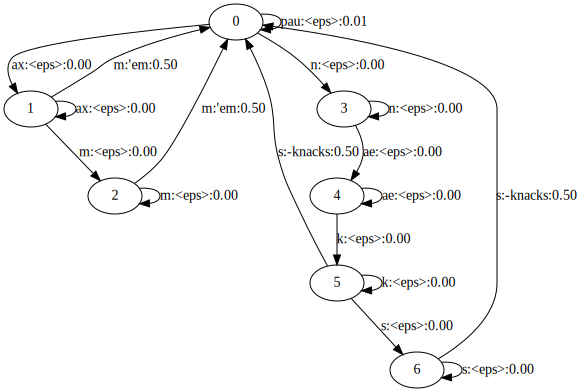

In [17]:
def create_Lwfst_from_file(dic_fname='../../asr_itmo_practice/timit/TIMITDIC.TXT', 
                           phones_fname='exp/phones.txt', 
                           words_fname='exp/words.txt', 
                           words_limit=-1, 
                           word_insertion_penalty=0.5, 
                           stay_in_silence_penalty=0.01):
    isymbols = SymbolsMap.from_file(phones_fname)
    osymbols = SymbolsMap.from_file(words_fname)
    sil_id = isymbols.get_id('pau')
    l_wfst = WFST(isymbols=isymbols, osymbols=osymbols)
    start = l_wfst.get_start()
    ### Пропуск скольких угодно фонем тишины
    l_wfst.add_arc(start, Arc(sil_id, 0, stay_in_silence_penalty, start))
    # Стартовое состояние также является и финальным
    l_wfst.set_final(start)
    
    for word, trans in load_lexicon_file(dic_fname, words_limit=words_limit):
        tran_ids = [isymbols.get_id(t) for t in trans]
        word_id = osymbols.get_id(word)
        # TODO 
        # Добавьте последовательные дуги в wfst, определяющие транскрипцию слова
        # Все дуги, кроме последней, на выходе имеют <eps>
        # Последняя дуга выводит word_id и возвращает конечный автомат в стартовое (оно же финальное) состояние
        # Каждая фонема может тянуться от 1 до inf кадров, поэтому помимо переходов в новое состояние, должны быть еще петли 
        trans_len = len(tran_ids)
        start_state = start
        for i in range(trans_len):
            if i == trans_len - 1:
                l_wfst.add_arc(start_state, Arc(tran_ids[i], word_id, word_insertion_penalty, start))
            new_state = l_wfst.new_state()
            l_wfst.add_arc(start_state, Arc(tran_ids[i], isymbols.get_id('<eps>'), 0, new_state)) # новое состояние
            l_wfst.add_arc(new_state, Arc(tran_ids[i], isymbols.get_id('<eps>'), 0, new_state))   # петли
            start_state = new_state 
        l_wfst.add_arc(start_state, Arc(tran_ids[i], word_id, word_insertion_penalty, start))
        
    return l_wfst

create_Lwfst_from_file(words_limit=2, word_insertion_penalty=0.5, stay_in_silence_penalty=0.01).to_dot()

In [18]:
def test_l_wfst():
    l_wfst = create_Lwfst_from_file(dic_fname='../../asr_itmo_practice/timit/TIMITDIC.TXT', 
                                    word_insertion_penalty=1.0, stay_in_silence_penalty=0.01)
    start = l_wfst.get_start()
    hyps = l_wfst.transduce(start, 'pau')
    loop_hyp = [(l, w, s) for l, w, s in hyps if s == start]
    assert (len(loop_hyp) == 1 
            and loop_hyp[0][0] == '<eps>' 
            and loop_hyp[0][1] == 0.01), f"{hyps}\n skip pause test failed"
    # смотрим, что поданная на вход транскрипция корректно переводится в слово
    # количество подряд идущих одинаковых фонем постепенно увеличивается от одной до 6
    for i, (word, trans) in enumerate(tqdm(load_lexicon_file('../../asr_itmo_practice/timit/TIMITDIC.TXT', words_limit=100), total=100)):
        hyps = [('', 0, l_wfst.get_start()), ]
        # Breadth First Search
        for t in [t for t in trans for _ in range(i//20+1)]:
            # t repeated many times
            new_hyps = []
            for prev_l, prev_w, prev_s in hyps: 
                new_hyps.extend([(f"{prev_l} {l}", prev_w + w, s) for l,w,s in l_wfst.transduce(prev_s, t)])
            hyps = new_hyps
        # choose only final hyp
        # ограничение веса нужно, чтобы отсечь гипотезы где комбинация других слов мапится на теже фонемы
        hyps = [(l, w, s) for l, w, s in hyps if l_wfst.final_score(s) != float('inf') and w == 1.0]
       
        assert len(hyps) == 1 or len(trans) == 1 , f"Test failed for word \"{word}\" {hyps=}"
        assert hyps[0][0].replace('<eps>', ' ').split() == [word], f"Test failed for word {word} {hyps=}"
        assert hyps[0][1] == 1.0, f"Test failed for word {word} {hyps=}"
        assert hyps[0][2] == start, f"Test failed for word {word} {hyps=}"       
    print("test 2.a passed")
test_l_wfst()

  0%|          | 0/100 [00:00<?, ?it/s]

test 2.a passed


# Поиск наилучшей гипотезы распознавания с помощью beam search

Для того, чтобы найти результат распознавания с помощью акустической модели и графа распознавания, надо выполнить поиск наилучшей гипотезы в графе. Для поиска лучшего пути будем использовать [лучевой поиск (Beam Search)](https://ru.wikipedia.org/wiki/%D0%9B%D1%83%D1%87%D0%B5%D0%B2%D0%BE%D0%B9_%D0%BF%D0%BE%D0%B8%D1%81%D0%BA). В основе этого алгоритма лежит обход графа в ширину, но на каждом шаге рассматриваются только наиболее "хорошие" гипотезы, а остальные уничтожаются. Такая эвристика позволяет значительно ускорить процесс декодирования, но не всегда находит наилучший путь. 

In [19]:
@dataclass(order=True)
class Hypothesis:
    # накопленный штраф гипотезы
    score: float
    # до какого кадра из входной последовательности дошла гипотеза
    time: int
    # накопленная последовательность слов
    words: List[str]
    # состояние графа декодирования 
    state: Any


### HypothesesKeeper
Реализуем специальную коллекцию, которая хранит все гипотезы распознавания и применяет прунинг (удаление ненужных гипотез). 
Прунинг делится на два типа: 
#### State pruning 
Eсли мы можем дойти до состояния X в момент времени T несколькими способами, то для дальнейшей обработки достаточно только наилучшего пути до состояния X. Эта гипотеза гарантированно будет лучше всех других гипотез, проходящих через точку (X, T). 
#### Beam pruning
Эвристика лучевого поиска. Отсекаем все гипотезы, которые хуже, чем лучшая текущая гипотеза плюс beam_size. Вероятность того, что гипотезы с сильно худшим весом вдруг станут наилучшими, крайне мала, поэтому такая эвристика работает достаточно хорошо. 


In [20]:
class HypothesesKeeper:
    def __init__(self, init_hyps: List[Hypothesis] = [], beam_size=10):
        self.state2hyp = {h.state: h for h in init_hyps}
        self.beam_size = beam_size
        if len(self.state2hyp) == 0:
            self.set_best(None, float('inf'))
        else:
            min_hyp = min(self.state2hyp.values())
            self.set_best(min_hyp.state, min_hyp.score)

    def set_best(self, state, score):
        self.best_state = state
        self.best_score = score
        
    def get_best_hyp(self) -> Hypothesis:
        """return the best hyp based on self.best_state"""
        # TODO 
        # верните лучшую гипотезу 
        return [hyp for state, hyp in self.state2hyp.items() if state == self.best_state and hyp.score == self.best_score][0]
    
    def prune(self):
        self.state2hyp = {s:h for s, h in self.state2hyp.items() if not self.is_prunned_by_beam(h.score)}
        
    def tolist(self) -> List[Hypothesis]:
        """Return all hypotheses. Apply beam pruning"""
        # TODO 
        # верните все гипотезы, которые находятся в луче поиска 
        self.prune()
        return self.state2hyp.values()
        
    def is_prunned_by_beam(self, score: float):
        """Return true if score greater than beam"""
        # TODO 
        # верните True, если значение score находится вне луча поиска 
        return score - self.beam_size > self.best_score
        
    def is_prunned_by_state(self, state, score):
        """Returns true if the keeper already has a hyp in the same state and the score of this hyp is lower"""
        # TODO
        # верните True, если state уже имеет гипотезу, со скором лучше чем score
        return state in self.state2hyp and self.state2hyp[state].score < score
    
    def append(self, hyp: Hypothesis):
        """Append new hyp into collection"""
        if self.is_prunned_by_beam(hyp.score) or self.is_prunned_by_state(hyp.state, hyp.score):
            return 
        self.state2hyp[hyp.state] = hyp
        if hyp.score < self.best_score or self.best_state is None:
            self.set_best(hyp.state, hyp.score)

    def extend(self, hyps):
        if isinstance(hyps, HypothesesKeeper):
            hyps = hyps.tolist()
        for h in hyps:
            self.append(h)
    
    def __len__(self):
        return len(self.state2hyp)

    def __str__(self):
        return '[' + ",\n".join(map(str, self.tolist())) + ']'

    def describe(self):
        # TODO 
        # посчитайте средний и максимальный скор хранящихся гипотез
        # mean_score = ...
        # max_score = ...
        scores = [hyp.score for hyp in self.state2hyp.values()]
        mean_score = sum(scores) / len(scores)
        max_score  = max(scores)
        return (
            f"{len(self)} hyps. "
            f"Best {self.get_best_hyp()}. "
            f"Mean score {mean_score:.2f}. "
            f"Max {max_score:.2f}"
        )

In [21]:
def test_hyp_keeper():
    hyps = HypothesesKeeper(beam_size=10)
    hyps.append(Hypothesis(10, 0, ['a'],  1))
    assert len(hyps) == 1 and hyps.best_state == 1 and hyps.best_score == 10, f"First append doesn't work well"
    hyps.append(Hypothesis(100, 0, ['err'], 2))
    assert len(hyps) == 1 and hyps.best_state == 1 and hyps.best_score == 10, f"Append didn't prune the input"
    
    hyps.append(Hypothesis(11, 0, ['b'], 2))
    assert len(hyps) == 2 and hyps.best_state == 1 and hyps.best_score == 10, f"Append doesn't work well"
    hyps.append(Hypothesis(12, 0, ['err2'], 2))
    assert len(hyps) == 2 and hyps.state2hyp[2].score == 11, f"Append didn't prune the input"
    
    hyps.append(Hypothesis(0, 0, ['c'], 3))
    assert hyps.best_state == 3 and hyps.best_score == 0, f"Append didn't update best_* attributes"

    hyps_list = hyps.tolist()
    assert len(hyps_list) == 2, f"tolist didn't prune the output"

    hyp = hyps.get_best_hyp()
    assert hyp == Hypothesis(0, 0, ['c'], 3), f"{hyp=}"
    print("test 2.b passed!")
test_hyp_keeper()

test 2.b passed!


In [22]:
class BeamSearcher:
    def __init__(self, am2phone_mapping, graph: AbstractWFST, beam_size=3):
        self.am2phone_mapping = am2phone_mapping
        self.graph = graph
        self.beam_size = beam_size
        
    def decode(self, phonemes_nll: np.ndarray):
        """
        Decoding input phonemes negative loglikelihood into word level hypthesis
        phonemes_logprobs.shape is (Time, num_phones)
        """
        parent_hyps = HypothesesKeeper(init_hyps=[Hypothesis(0, -1, [], self.graph.get_start())], 
                                       beam_size=self.beam_size)
        pbar = tqdm(phonemes_nll)
        for new_time, frame_dist in enumerate(pbar):
            new_hyps = HypothesesKeeper(beam_size=self.beam_size)
            for parent_hyp in parent_hyps.tolist():
                assert parent_hyp.time + 1 == new_time, f"Wrong time {new_time=}, \n{parent_hyp=}"
                # TODO 
                # Продолжите гипотезу parent_hyp с помощью всех фонем и их вероятностей из frame_dist
                # соханите новые гипотезы в new_hyps
                # words гипотез не должен содержать <eps> 
                # score гипотезы равен сумме скора родителя, phone_nll и веса от transduce по графу 
                for i, phone_nll in enumerate(frame_dist):
                    trans = self.graph.transduce(parent_hyp.state, self.am2phone_mapping[i])
                    for tran in trans:
                        score = parent_hyp.score + phone_nll + tran[1]
                        words = parent_hyp.words + ([] if tran[0] == "<eps>" else [tran[0]])
                        state = tran[2]
                        time  = parent_hyp.time  + 1
                        new_hyp = Hypothesis(score=score, time=time, words=words, state=state)
                        new_hyps.append(new_hyp)
            new_hyps.prune() 
            parent_hyps = new_hyps 
            statictic_str = parent_hyps.describe() 
            pbar.set_description(statictic_str, refresh=False) 
        # TODO 
        # сформируйте список финальных гипотез
        # пройдитесь по parent_hyps и добавьте ко всем гипотезам финальный вес 
        final_hyps = HypothesesKeeper(beam_size=self.beam_size)
        for parent_hyp in parent_hyps.tolist():
            final_score = self.graph.final_score(parent_hyp.state)
            parent_hyp.score += final_score
            final_hyps.append(parent_hyp)
        
        print(f"Found {len(final_hyps)} hypotheses")
        best_hyp = final_hyps.get_best_hyp()
        return best_hyp

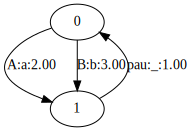

  0%|          | 0/3 [00:00<?, ?it/s]

Found 1 hypotheses


  0%|          | 0/3 [00:00<?, ?it/s]

Found 1 hypotheses


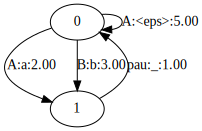

  0%|          | 0/3 [00:00<?, ?it/s]

Found 1 hypotheses


  0%|          | 0/3 [00:00<?, ?it/s]

Found 1 hypotheses


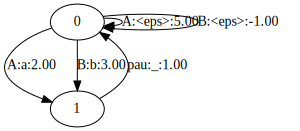

  0%|          | 0/3 [00:00<?, ?it/s]

Found 1 hypotheses
Test 2.c passed


In [23]:
def test_beam_search():
    
    graph = WFST(isymbols=SymbolsMap(id2symbol=['<eps>', 'pau', 'A', 'B']),
                 osymbols=SymbolsMap(id2symbol=['<eps>', 'err', '_', 'a', 'b']))
    s = graph.new_state()
    graph.add_arc(0, Arc(2, 3, 2.0, s))
    graph.add_arc(0, Arc(3, 4, 3.0, s))
    graph.add_arc(s, Arc(1, 2, 1.0, 0))
    graph.set_final(s)

    display.display(graph.to_dot())
                 
    searcher = BeamSearcher(am2phone_mapping={0: 'pau', 1: 'A', 2: 'B'}, graph=graph, beam_size=10)
    #                   p  A  B
    logits = np.array([[-1, -1, -1],
                       [0, 0, 0],
                       [-100, -100, -100]])
    best_hyp = searcher.decode(logits)
    assert best_hyp == Hypothesis((-1+2) + (-0+1) + (-100+2) , 2, ['a', '_', 'a'], s), best_hyp
    logits = np.array([[1, 4, 1],
                       [100, 0, 0],
                       [100, 100, 100]])
    best_hyp = searcher.decode(logits)
    assert best_hyp == Hypothesis((1+3) + (100+1) + (100+2) , 2, ['b', '_', 'a'], s), best_hyp
    
    searcher.graph.add_arc(0, Arc(2, 0, 5.0, 0))
    display.display(searcher.graph.to_dot())
    logits = np.array([[1, 2, 0],
                       [10, 0, 0],
                       [100, 100, 100]])
    best_hyp = searcher.decode(logits)
    assert best_hyp == Hypothesis((2+5) + (0+5) + (100+2) , 2, ['a'], s), best_hyp

    logits = np.array([[1, 20, 4], # beam pruning must remove A-loop hypothesis
                       [1000, 0, 0],
                       [100, 100, 100]])
    best_hyp = searcher.decode(logits)
    assert best_hyp == Hypothesis((4+3) + (1000+1) + (100+2) , 2, ['b', '_', 'a'], s), best_hyp

    searcher.graph.add_arc(0, Arc(3, 0, -1, 0))
    display.display(searcher.graph.to_dot())
    logits = np.array([[1, 2, 0],
                       [10, 0, 0],
                       [100, 100, 100]])
    best_hyp = searcher.decode(logits)
    assert best_hyp == Hypothesis((0-1) + (0-1) + (100+2) , 2, ['a'], s), best_hyp

    print(f"Test 2.c passed")
test_beam_search()                      

### WFST представление нграмной языковой модели 
Для подсчета языковой модели будем использовать библиотеку kenlm. Данная библиотека позволяет подсчитывать языковую вероятность с помощью нграмной языковой модели. 

Создадим обертку над kenlm.Model, реализующую интерфейс AbstractWFST

In [24]:
class kenlmLikeWFST(AbstractWFST):
    """Оборачиваем kenlm в унифицированный интерфейс"""
    def __init__(self, lm: kenlm.Model, lmwt_factor=0.01):
        self.lm = lm
        self.lmwt_factor = lmwt_factor
        
    def get_start(self):
        state = kenlm.State()
        self.lm.BeginSentenceWrite(state)
        return state
        
    def final_score(self, state: kenlm.State):
        logprob = self.lm.BaseScore(state, "</s>", kenlm.State())
        return self._log10_to_nll(logprob)
        
    def _log10_to_nll(self, logprob):
        """переводим в negative натуральный логирифм """
        return - np.log(10**logprob)
        
    def transduce(self, state: kenlm.State, ilabel: str):
        assert isinstance(ilabel, str), ilabel
        if ilabel == '<eps>':
            # skip <eps> input
            return [('<eps>', 0, state), ]
        state2 = kenlm.State()
        logprob = self.lm.BaseScore(state, ilabel, state2)
        return [(ilabel, self.lmwt_factor * self._log10_to_nll(logprob), state2), ]
    

## Запускаем декодирование


In [25]:
# Заранее подготовленные negative log probability от модели из работы №3
with ReadHelper('ark:resources/lab4/test_am_nlogprobs.ark') as am_nlogprob_reader:
    am_nlogprobs = {uri: am_logprob  for uri, am_logprob in am_nlogprob_reader}

In [26]:
# Выбираем один пример для отладки пайплайна
example = am_nlogprobs['timit/data/TEST/DR1/FAKS0/SA1']
with open('../../asr_itmo_practice/timit/data/TEST/DR1/FAKS0/SA1.TXT') as f:
    example_ref = ' '.join(f.read().replace('.', ' ').split()[2:])
print(example_ref)

She had your dark suit in greasy wash water all year


In [27]:
h_fst = create_h_wfst()
l_fst = create_Lwfst_from_file(stay_in_silence_penalty=0.0, word_insertion_penalty=1.0)

In [28]:
# пробуем разные варианты
ASR = BeamSearcher(am2phone_mapping=AM_PHONES, 
                   graph=OnTheFlyCompose([h_fst, l_fst]),
                   beam_size=0)   
hyp = ASR.decode(example)
print(hyp, "WER: ", jiwer.wer(example_ref, ' '.join(hyp.words)))

# Hypothesis(score=inf, time=197, words=[], state=(0, 28541)) WER:  1.0

  0%|          | 0/198 [00:00<?, ?it/s]

Found 1 hypotheses
Hypothesis(score=inf, time=197, words=[], state=(0, 28541)) WER:  1.0


In [29]:
ASR = BeamSearcher(am2phone_mapping=AM_PHONES, 
                   graph=OnTheFlyCompose([h_fst, l_fst]),
                   beam_size=6)
hyp = ASR.decode(example)
print(hyp, "WER: ", jiwer.wer(example_ref, ' '.join(hyp.words)))

# Hypothesis(score=-634.8072872315479,
# time=197, 
# words=['she', 'had', 'your', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'year'],
# state=(0, 0)) WER:  0.09090909090909091

  0%|          | 0/198 [00:00<?, ?it/s]

Found 1 hypotheses
Hypothesis(score=-634.8072872315479, time=197, words=['she', 'had', 'your', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'year'], state=(0, 0)) WER:  0.09090909090909091


In [30]:
lm = kenlmLikeWFST(kenlm.LanguageModel('resources/lab4/3gram.arpa'), lmwt_factor=0.2)
ASR = BeamSearcher(am2phone_mapping=AM_PHONES, 
                   graph=OnTheFlyCompose([h_fst, l_fst, lm]), 
                   beam_size=6) 
hyp = ASR.decode(example)
print(hyp, "WER: ", jiwer.wer(example_ref, ' '.join(hyp.words))) 

# Hypothesis(score=-624.2866933483066, 
# time=197, 
# words=['she', 'had', 'your', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'year'], 
# state=(0, 0, <kenlm.State object at 0x7fa93c7c1070>)) WER:  0.09090909090909091 

Loading the LM will be faster if you build a binary file.
Reading /mnt/storage/kocharyan/additional_asr/asr_itmo_practice/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************


  0%|          | 0/198 [00:00<?, ?it/s]

Found 1 hypotheses
Hypothesis(score=inf, time=197, words=['she', 'had', 'your', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'year'], state=(0, 0, <kenlm.State object at 0x7f69547236f0>)) WER:  0.09090909090909091


### финальное задание
Постройте графики зависимости WER на example и времени работы декодирования от таких параметров как: 
* lmwt_factor
* stay_in_silence_penalty
* word_insertion_penalty
* beam

Выберите оптимальные по соотношению WER/time параметры. 

In [31]:
#TODO
from functools import partial
from itertools import product
import pandas as pd
from copy import copy, deepcopy
import time
import matplotlib.pyplot as plt


def calculate_wer(lmwt_factor, stay_in_silence_penalty, word_insertion_penalty, beam, example, example_ref):
    
    h_fst = create_h_wfst()
    create_Lwfst_from_file(stay_in_silence_penalty=stay_in_silence_penalty, word_insertion_penalty=word_insertion_penalty)
    lm = kenlmLikeWFST(kenlm.LanguageModel('resources/lab4/3gram.arpa'), lmwt_factor=lmwt_factor)
    graph = OnTheFlyCompose([h_fst, l_fst, lm])
    ASR = BeamSearcher(am2phone_mapping=AM_PHONES, graph=graph, beam_size=beam)
    
    start_time = time.time()
    hyp = ASR.decode(example)
    exec_time = time.time() - start_time
    
    return jiwer.wer(example_ref, ' '.join(hyp.words)), exec_time


def brute_force():
    
    params_grid = {
        "lmwt_factor": [0., .01, .05, .1], 
        "stay_in_silence_penalty": [0., .025, .1, .5], 
        "word_insertion_penalty": [0, .5, 1.5, 3.], 
        "beam": [1, 2, 4, 6],
    }
    # TODO: При наличии времени наверное можно проанализировать на всем декартовом произведении
    # Однако на данный момент можно оставить параметры (закрепить) по умолчанию и перебирать только один из них
    # Дефолтные значения параметров из сигнатур функций, определенных выше :
    default_params = {"lmwt_factor": 0.01, "stay_in_silence_penalty": 0.01, "word_insertion_penalty":0.5, "beam": 3}
    partial_wer = partial(calculate_wer, example=example, example_ref=example_ref)
    results = []

    # plt.ioff()
    # fig, axs = plt.subplots(1, 2, figsize=(15, 8), sharex=False, sharey=False)
    
    for j, params in enumerate(params_grid):
        
        kwargs          = copy(default_params)
        wers_per_param  = []
        times_per_param = []
        
        for i, param in enumerate(params_grid[params]):
            
            kwargs[params] = param
            wer, time = partial_wer(**kwargs)
            results.append({**kwargs, **{"WER": wer, "time": time}})
            
            # wers_per_param.append(wer)
            # times_per_param.append(time)

        # ax = axs[j//2, j%2]
        # ax.plot(params_grid[params], wers_per_param, label=f'{params}')
        # ax.plot(params_grid[params], times_per_param, label=f'times')
        # ax.legend()
        # ax.set_title(f'variations of {params}')
    
    return pd.DataFrame(results) # , plt

In [152]:
df = brute_force()

Loading the LM will be faster if you build a binary file.
Reading /mnt/storage/kocharyan/additional_asr/asr_itmo_practice/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************


  0%|          | 0/198 [00:00<?, ?it/s]

Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /mnt/storage/kocharyan/additional_asr/asr_itmo_practice/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************


  0%|          | 0/198 [00:00<?, ?it/s]

Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /mnt/storage/kocharyan/additional_asr/asr_itmo_practice/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************


  0%|          | 0/198 [00:00<?, ?it/s]

Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /mnt/storage/kocharyan/additional_asr/asr_itmo_practice/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************


  0%|          | 0/198 [00:00<?, ?it/s]

Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /mnt/storage/kocharyan/additional_asr/asr_itmo_practice/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************


  0%|          | 0/198 [00:00<?, ?it/s]

Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /mnt/storage/kocharyan/additional_asr/asr_itmo_practice/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************


  0%|          | 0/198 [00:00<?, ?it/s]

Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /mnt/storage/kocharyan/additional_asr/asr_itmo_practice/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************


  0%|          | 0/198 [00:00<?, ?it/s]

Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /mnt/storage/kocharyan/additional_asr/asr_itmo_practice/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************


  0%|          | 0/198 [00:00<?, ?it/s]

Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /mnt/storage/kocharyan/additional_asr/asr_itmo_practice/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************


  0%|          | 0/198 [00:00<?, ?it/s]

Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /mnt/storage/kocharyan/additional_asr/asr_itmo_practice/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************


  0%|          | 0/198 [00:00<?, ?it/s]

Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /mnt/storage/kocharyan/additional_asr/asr_itmo_practice/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************


  0%|          | 0/198 [00:00<?, ?it/s]

Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /mnt/storage/kocharyan/additional_asr/asr_itmo_practice/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************


  0%|          | 0/198 [00:00<?, ?it/s]

Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /mnt/storage/kocharyan/additional_asr/asr_itmo_practice/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************


  0%|          | 0/198 [00:00<?, ?it/s]

Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /mnt/storage/kocharyan/additional_asr/asr_itmo_practice/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************


  0%|          | 0/198 [00:00<?, ?it/s]

Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /mnt/storage/kocharyan/additional_asr/asr_itmo_practice/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************


  0%|          | 0/198 [00:00<?, ?it/s]

Found 1 hypotheses


Loading the LM will be faster if you build a binary file.
Reading /mnt/storage/kocharyan/additional_asr/asr_itmo_practice/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************


  0%|          | 0/198 [00:00<?, ?it/s]

Found 2 hypotheses


In [160]:
df

,lmwt_factor,stay_in_silence_penalty,word_insertion_penalty,beam,WER,time
0,0.00,0.010,0.5,3,0.090909,75.078274
1,0.01,0.010,0.5,3,0.090909,74.374061
2,0.05,0.010,0.5,3,0.090909,73.411841
3,0.10,0.010,0.5,3,0.181818,77.330789
4,0.01,0.000,0.5,3,0.090909,74.544018
5,0.01,0.025,0.5,3,0.090909,74.268502
6,0.01,0.100,0.5,3,0.090909,74.480477
7,0.01,0.500,0.5,3,0.090909,74.329053
8,0.01,0.010,0.0,3,0.090909,74.143418
9,0.01,0.010,0.5,3,0.090909,41.336970


In [161]:
def graphs(data, names, drow):
    
    plt.ioff()
    fig, axs = plt.subplots(2, 2, figsize=(15, 8), sharex=False, sharey=False)
    
    for j in range(4):
        
        ax = axs[j//2, j%2]
        
        params, wers_per_param = data[j]
        ax.plot(params, wers_per_param, label=f'{names[j]}_{drow}')
        # ax.legend()
        ax.set_title(f'variations {names[j]}: {drow}')
        
    return plt



In [162]:
# TODO: change
# lmwt_factor_df = df.iloc[:3, :]
# stay_in_silence_penalty_df = df.iloc[3:6, :]
# word_insertion_penalty_df = df.iloc[6:9, :]
# beam_df = df.iloc[9:12, :]
# data = [lmwt_factor_df, stay_in_silence_penalty_df, word_insertion_penalty, beam_df]
data = []
for i in range(len(df)//4):
    data.append(df.iloc[i*4:i*4+4, :])

In [163]:
def get_data_with_label(data, names, label):
    res = []
    for i in range(len(data)):
        res.append([
            data[i][names[i]].tolist(),
            data[i][label].tolist(),
        ])
    return res

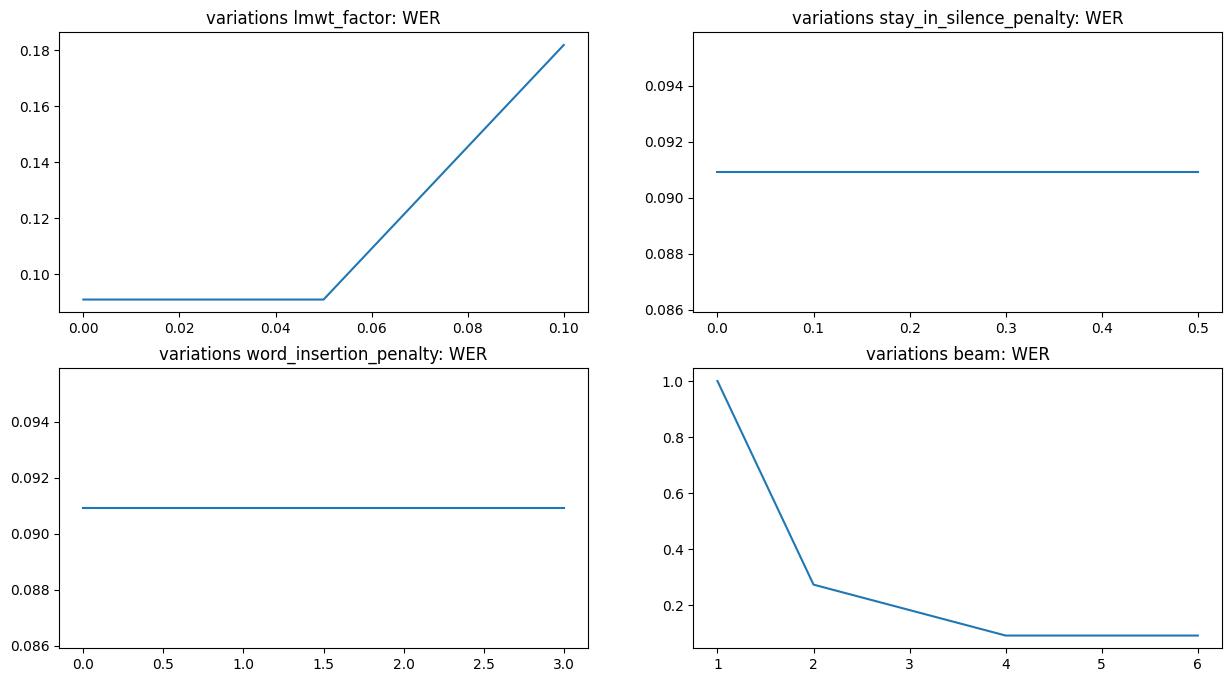

In [164]:
names = ["lmwt_factor", "stay_in_silence_penalty", "word_insertion_penalty", "beam"]
metric = "WER"
graphs(get_data_with_label(data, names, metric), names, metric).show()

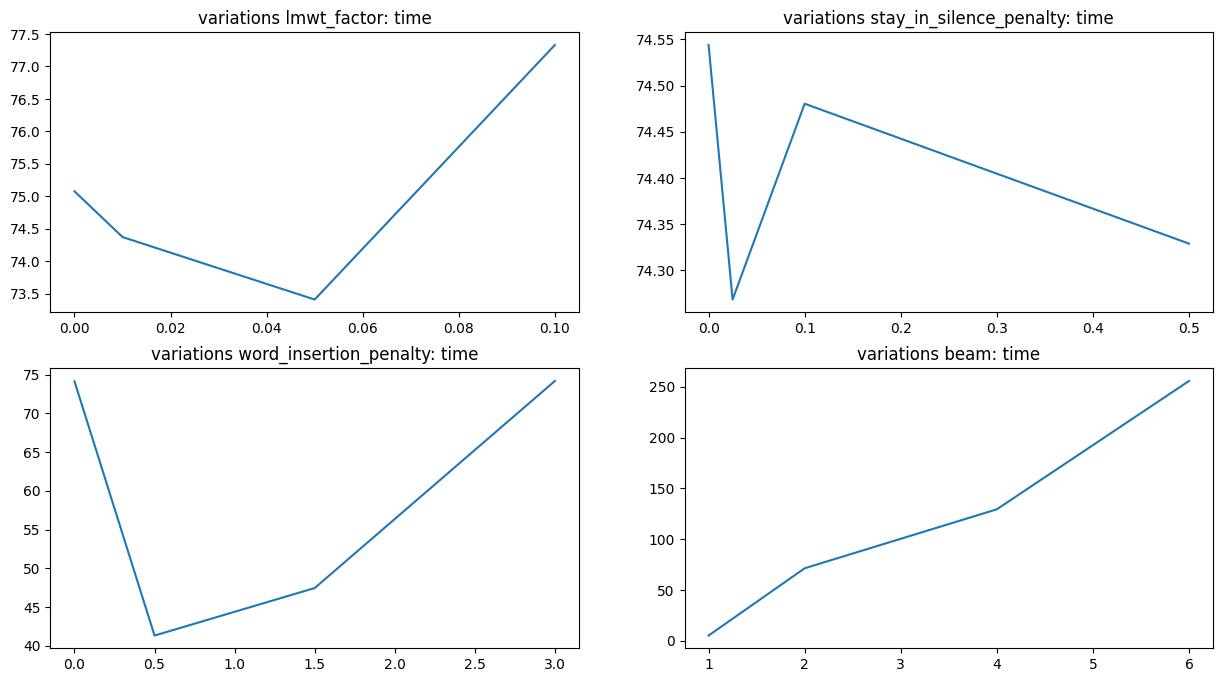

In [165]:
names = ["lmwt_factor", "stay_in_silence_penalty", "word_insertion_penalty", "beam"]
metric = "time"
graphs(get_data_with_label(data, names, metric), names, metric).show()

**Небольшие выводы**

Был проделан небольшой перебор параметров, из чего получилось выявить:

- увеличение параметра beam приводит к уменьшению WER, так как в этом случае в распоряжении модели большее пространство решений, которые можно проанализировать, однако в тоже время это приводит к увеличении вычислительной сложности (причем явно). Кажется, что в данном эксперименте в какой-то момент, увеличение beam не дает прироста. 
- Кажется, с помощью lmwt_factor можно варьировать влияние языковой модели на результат декодирования (вроде на лекциях об этом говорили, что в зависимости от задачи, у нас по разному могут работать акустические и языковые модели, поэтому можно по разному учитывать их влияние). В данном случае увеличение lmwt_factor приводит к увеличению WER, что говорит о том, что наша акустическая модель работает лучше. На производительность данный параметр не сильно влияет
- Исходя из экспериментов, параметры stay_in_silence_penalty/word_insertion_penalty не влияют на значение метрик. Но интуиция (и фантазия) подсказывает, что изменение этих параметров может влиять на производительность и сами метрики (например, при наличии шумов, наверное, можно отдавать предпочтение большему количеству пауз, а при необходимости оптимизации скорости, возможно имеет смысл увеличить word_insertion_penalty чтобы снизить количество различных гипотез на выходе). В данном случае, как-будто, это не очевидно.



# Дополнительное задание (2 балла)
Декодируйте всю коллекцию am_nlogprobs с подобраными ранее параметрами и посчитайте WER на этой выборке


In [35]:
#TODO

In [56]:
h_fst = create_h_wfst()
create_Lwfst_from_file(stay_in_silence_penalty=.01, word_insertion_penalty=.5)
lm = kenlmLikeWFST(kenlm.LanguageModel('resources/lab4/3gram.arpa'), lmwt_factor=.02)
graph = OnTheFlyCompose([h_fst, l_fst, lm])
ASR = BeamSearcher(am2phone_mapping=AM_PHONES, graph=graph, beam_size=4)

Loading the LM will be faster if you build a binary file.
Reading /mnt/storage/kocharyan/additional_asr/asr_itmo_practice/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************


In [59]:
from IPython.display import clear_output
from joblib import Parallel, delayed

def get_data():
    examples     = []
    example_refs = []
    for key, example in am_nlogprobs.items():
        examples.append(example)
        with open('../../asr_itmo_practice/' + key + '.TXT') as f:
            example_ref = ' '.join(f.read().replace('.', ' ').split()[2:])
        example_refs.append(example_ref)
    return example_refs, examples


def _decode(asr, example):
    hyp = ASR.decode(example)
    # clear_output(wait=False)
    return ' '.join(hyp.words)


def decode(asr, examples):

    texts = Parallel(n_jobs=-1)(delayed(_decode)(asr, example) for example in examples)

    # texts = []
    # for example in examples: # TODO: Parallel
    #     texts.append(_decode(asr, example))
    
    return texts

def calc_wer(example, example_ref):
    return jiwer.wer(example_ref, example)

In [60]:
example_refs, examples = get_data()
examples = decode(ASR, examples)

Loading the LM will be faster if you build a binary file.
Reading /mnt/storage/kocharyan/additional_asr/asr_itmo_practice/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
Loading the LM will be faster if you build a binary file.
Reading /mnt/storage/kocharyan/additional_asr/asr_itmo_practice/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
Loading the LM will be faster if you build a binary file.
Reading /mnt/storage/kocharyan/additional_asr/asr_itmo_practice/resources/lab4/3gram.arpa
----5---10--

Found 1 hypotheses


453 hyps. Best Hypothesis(score=-336.25304922792174, time=91, words=['drop', 'five', 'forms', 'in'], state=(0, 32429, <kenlm.State object at 0x7f37e4273730>)). Mean score -334.14. Max -332.73:  52%|█████▏    | 92/176 [01:01<01:21,  1.04it/s][00:59<00:34,  2.58it/s]  | 183/248 [01:03<00:40,  1.62it/s]Loading the LM will be faster if you build a binary file.
Reading /mnt/storage/kocharyan/additional_asr/asr_itmo_practice/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
1 hyps. Best Hypothesis(score=-8.77736646115301, time=1, words=[], state=(0, 0, <kenlm.State object at 0x7f4d72cbe0f0>)). Mean score -8.78. Max -8.78:   1%|          | 2/220 [00:00<00:18, 12.06it/s]  | 46/167 [01:01<13:43,  6.80s/it]19/207 [00:59<00:30,  2.84it/s] 

2 hyps. Best Hypothesis(score=-537.696280042167, time=180, words=['own', 'ask', 'meeting', 'care', 'reinforce', 'oily', 'rag', 'like', 'that'], state=(0, 0, <kenlm.State object at 0x7f964c43bbf0>)). Mean score -536.87. Max -536.05: 100%|██████████| 181/181 [01:07<00:00,  2.69it/s] 07<00:36,  1.61it/s]
310 hyps. Best Hypothesis(score=-482.3504875072503, time=130, words=['the', 'reasons', 'full', 'this', 'tie', "i've", 'seemed'], state=(0, 11889, <kenlm.State object at 0x7ff2003a0470>)). Mean score -482.35. Max -482.35:  75%|███████▍  | 131/175 [01:06<00:50,  1.15s/it]

Found 2 hypotheses


316 hyps. Best Hypothesis(score=-490.56331547398355, time=132, words=['the', 'reasons', 'full', 'this', 'tie', "i've", 'seemed'], state=(0, 11889, <kenlm.State object at 0x7ff2003a0470>)). Mean score -490.51. Max -487.89:  76%|███████▌  | 133/175 [01:07<00:32,  1.27it/s]Loading the LM will be faster if you build a binary file.
Reading /mnt/storage/kocharyan/additional_asr/asr_itmo_practice/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
181 hyps. Best Hypothesis(score=-386.2845332711193, time=123, words=['she', 'had', 'your', 'dark', 'suit', 'in', 'greasy'], state=(0, 21680, <kenlm.State object at 0x7ff4552ac470>)). Mean score -386.28. Max -386.28:  63%|██████▎   | 124/198 [01:08<00:23,  3.09it/s]51it/s]

394 hyps. Best Hypothesis(score=-126.9539977947728, time=121, words=['elderly', 'people', 'are', 'off', 'negotiations'], state=(0, 7948, <kenlm.State object at 0x7f0f061fc330>)). Mean score -126.39. Max -123.00: 100%|██████████| 122/122 [01:06<00:00,  1.83it/s]t/s]▊  | 193/248 [01:09<00:35,  1.54it/s]


Found 394 hypotheses


400 hyps. Best Hypothesis(score=-464.1015008018991, time=155, words=['she', 'head', 'your', 'dark', 'suit', 'tin', 'greasy'], state=(0, 21680, <kenlm.State object at 0x7f3c88c50a30>)). Mean score -462.33. Max -460.69:  59%|█████▉    | 156/263 [01:06<00:35,  3.05it/s] Loading the LM will be faster if you build a binary file.
Reading /mnt/storage/kocharyan/additional_asr/asr_itmo_practice/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
  0%|          | 0/371 [00:00<?, ?it/s]58488793187, time=133, words=['she', 'had', 'your', 'dark', 'suit', 'in', 'greasy'], state=(0, 35327, <kenlm.State object at 0x7ff4552ac470>)). Mean score -416.42. Max -415.62:  68%|██████▊   | 134/198 [01:10<00:17,  3.68it/s]

1 hyps. Best Hypothesis(score=-502.1782225891171, time=164, words=['pizzerias', 'are', 'convenient', 'fur', 'a', 'quick', 'lunch'], state=(0, 0, <kenlm.State object at 0x7ff4a42fa8b0>)). Mean score -502.18. Max -502.18: 100%|██████████| 165/165 [01:12<00:00,  2.28it/s]s]01/248 [01:13<00:16,  2.87it/s]


Found 1 hypotheses


266 hyps. Best Hypothesis(score=-297.9635203930291, time=79, words=['husky', 'young', 'men'], state=(0, 14531, <kenlm.State object at 0x7f4d738037b0>)). Mean score -297.96. Max -297.96:  36%|███▋      | 80/220 [00:10<00:35,  4.00it/s]Loading the LM will be faster if you build a binary file.
Reading /mnt/storage/kocharyan/additional_asr/asr_itmo_practice/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
144 hyps. Best Hypothesis(score=-583.8097992414984, time=155, words=['the', 'reasons', 'full', 'this', 'tie', "i've", 'seemed', 'foolish'], state=(0, 3, <kenlm.State object at 0x7ff2007504f0>)). Mean score -583.79. Max -582.12:  89%|████████▉ | 156/175 [01:13<00:05,  3.23it/s]****************************************************************************************************
871 hyps. Best Hypothesis(score=-423.241712934348, time=143, words=["

1 hyps. Best Hypothesis(score=-670.1835574469491, time=174, words=['the', 'reasons', 'full', 'this', 'tie', "i've", 'seemed', 'foolish', 'now'], state=(0, 0, <kenlm.State object at 0x7ff2000644b0>)). Mean score -670.18. Max -670.18: 100%|██████████| 175/175 [01:16<00:00,  2.29it/s]:16<00:39,  1.14it/s]


Found 1 hypotheses


321 hyps. Best Hypothesis(score=-86.08098947867927, time=21, words=['hum'], state=(0, 15502, <kenlm.State object at 0x7f964f1d2a70>)). Mean score -83.28. Max -82.10:  10%|▉         | 22/229 [00:09<01:36,  2.14it/s]-496.92:  80%|███████▉  | 158/198 [01:17<00:06,  5.95it/s] s]Loading the LM will be faster if you build a binary file.
Reading /mnt/storage/kocharyan/additional_asr/asr_itmo_practice/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
210 hyps. Best Hypothesis(score=-601.3612611298583, time=192, words=['she', 'head', 'your', 'dark', 'suit', 'tin', 'greasy', 'wash'], state=(0, 21680, <kenlm.State object at 0x7f3c88fe2e30>)). Mean score -600.83. Max -597.53:  73%|███████▎  | 193/263 [01:14<00:14,  4.80it/s]

1 hyps. Best Hypothesis(score=-770.7899070126075, time=247, words=['his', 'calf', 'tin', 'was', 'thin', 'none', 'haggard', 'end', 'is', 'beautiful', 'boots', 'worn', 'enter', 'chastity'], state=(0, 0, <kenlm.State object at 0x7f784ea7fcf0>)). Mean score -770.79. Max -770.79: 100%|██████████| 248/248 [01:32<00:00,  2.68it/s]
355 hyps. Best Hypothesis(score=-95.72177970281494, time=23, words=['the'], state=(0, 20223, <kenlm.State object at 0x7ff1fd500b30>)). Mean score -93.36. Max -91.85:  11%|█         | 24/221 [00:14<02:09,  1.52it/s]71. Max -567.86:  91%|█████████▏| 189/207 [01:28<00:04,  3.99it/s]

Found 1 hypotheses


21 hyps. Best Hypothesis(score=-593.9441767438055, time=187, words=['she', 'had', 'your', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'year'], state=(0, 10060, <kenlm.State object at 0x7ff45516c4b0>)). Mean score -593.15. Max -590.54:  95%|█████████▍| 188/198 [01:33<00:04,  2.20it/s] Loading the LM will be faster if you build a binary file.
Reading /mnt/storage/kocharyan/additional_asr/asr_itmo_practice/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
17 hyps. Best Hypothesis(score=-598.7164359949534, time=189, words=['she', 'had', 'your', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'year'], state=(0, 0, <kenlm.State object at 0x7ff454b749f0>)). Mean score -595.05. Max -594.83:  96%|█████████▌| 190/198 [01:33<00:02,  

1 hyps. Best Hypothesis(score=-633.8096690610141, time=197, words=['she', 'had', 'your', 'dark', 'suit', 'in', 'greasy', 'wash', 'water', 'all', 'year'], state=(0, 0, <kenlm.State object at 0x7ff454b749f0>)). Mean score -633.81. Max -633.81: 100%|██████████| 198/198 [01:34<00:00,  2.10it/s] 
3 hyps. Best Hypothesis(score=-164.83452532948846, time=120, words=['her', 'wore', 'drove', 'concessionaire', 'eastern'], state=(0, 33513, <kenlm.State object at 0x7fd779208930>)). Mean score -162.88. Max -160.92:  72%|███████▏  | 121/167 [01:31<00:02, 16.63it/s]  :02,  4.62it/s]

Found 1 hypotheses


3 hyps. Best Hypothesis(score=-615.7617722183114, time=198, words=["don't", 'ask', 'meeting', 'carry', 'enjoy', 'oily', 'rag', 'lie', 'that'], state=(0, 0, <kenlm.State object at 0x7f9f65220bf0>)). Mean score -613.62. Max -611.77:  96%|█████████▌| 199/207 [01:30<00:02,  3.74it/s]Loading the LM will be faster if you build a binary file.
Reading /mnt/storage/kocharyan/additional_asr/asr_itmo_practice/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
1 hyps. Best Hypothesis(score=-61.47476741656801, time=13, words=[], state=(0, 0, <kenlm.State object at 0x7f78524d2530>)). Mean score -61.47. Max -61.47:   7%|▋         | 14/210 [00:01<00:19,  9.94it/s] 

3 hyps. Best Hypothesis(score=-650.8860979249085, time=206, words=["don't", 'ask', 'meeting', 'carry', 'enjoy', 'oily', 'rag', 'lie', 'that'], state=(0, 0, <kenlm.State object at 0x7f9f65220bf0>)). Mean score -648.75. Max -646.90: 100%|██████████| 207/207 [01:32<00:00,  2.25it/s] 1.34it/s]
446 hyps. Best Hypothesis(score=-687.3311837534787, time=224, words=['she', 'head', 'your', 'dark', 'suit', 'tin', 'greasy', 'wash', 'wall', 'does'], state=(0, 1040, <kenlm.State object at 0x7f3c88b0f170>)). Mean score -685.78. Max -683.35:  86%|████████▌ | 225/263 [01:32<00:28,  1.35it/s]

Found 3 hypotheses


446 hyps. Best Hypothesis(score=-690.9157766601329, time=225, words=['she', 'head', 'your', 'dark', 'suit', 'tin', 'greasy', 'wash', 'wall', 'does'], state=(0, 1040, <kenlm.State object at 0x7f3c88b0f170>)). Mean score -689.39. Max -687.38:  86%|████████▌ | 226/263 [01:33<00:27,  1.35it/s]Loading the LM will be faster if you build a binary file.
Reading /mnt/storage/kocharyan/additional_asr/asr_itmo_practice/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
72 hyps. Best Hypothesis(score=-561.5131428077405, time=161, words=['drop', 'five', 'forms', 'in', 'the', 'box', 'before', 'you', 'go'], state=(0, 15496, <kenlm.State object at 0x7f37e4182770>)). Mean score -560.72. Max -560.31:  92%|█████████▏| 162/176 [01:35<00:01,  8.03it/s]

1 hyps. Best Hypothesis(score=-606.9527891960923, time=175, words=['drop', 'five', 'forms', 'in', 'the', 'box', 'before', 'you', 'go', 'out'], state=(0, 0, <kenlm.State object at 0x7f37e47a3630>)). Mean score -606.95. Max -606.95: 100%|██████████| 176/176 [01:36<00:00,  1.83it/s] 1.35it/s]
728 hyps. Best Hypothesis(score=-102.0228039881811, time=26, words=['the', "'em"], state=(0, 21679, <kenlm.State object at 0x7ff1fd48ce30>)). Mean score -100.53. Max -98.27:  12%|█▏        | 27/221 [00:20<05:45,  1.78s/it]34<00:29,  3.84it/s]

Found 1 hypotheses


435 hyps. Best Hypothesis(score=-385.6383180252368, time=109, words=['husky', 'young', 'men', 'he'], state=(0, 27547, <kenlm.State object at 0x7f4d73b539b0>)). Mean score -382.31. Max -381.77:  50%|█████     | 110/220 [00:35<00:25,  4.35it/s]Loading the LM will be faster if you build a binary file.
Reading /mnt/storage/kocharyan/additional_asr/asr_itmo_practice/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
1236 hyps. Best Hypothesis(score=-697.6568554502021, time=227, words=['she', 'head', 'your', 'dark', 'suit', 'tin', 'greasy', 'wash', 'wall', 'does'], state=(0, 1040, <kenlm.State object at 0x7f3c88b0f170>)). Mean score -695.42. Max -693.67:  87%|████████▋ | 228/263 [01:35<00:32,  1.07it/s]

10 hyps. Best Hypothesis(score=-147.8795788342902, time=166, words=['her', 'wore', 'drove', 'concessionaire', 'eastern', 'tsunami'], state=(0, 31623, <kenlm.State object at 0x7fd7789275f0>)). Mean score -145.42. Max -144.14: 100%|██████████| 167/167 [01:39<00:00,  1.67it/s]  :42,  1.24s/it]


Found 10 hypotheses


1323 hyps. Best Hypothesis(score=-704.3225026218597, time=229, words=['she', 'head', 'your', 'dark', 'suit', 'tin', 'greasy', 'wash', 'wall', 'does'], state=(0, 1041, <kenlm.State object at 0x7f3c88b0f170>)). Mean score -702.17. Max -700.34:  87%|████████▋ | 230/263 [01:39<00:49,  1.50s/it]Loading the LM will be faster if you build a binary file.
Reading /mnt/storage/kocharyan/additional_asr/asr_itmo_practice/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
1 hyps. Best Hypothesis(score=-4.389546675451499, time=0, words=[], state=(0, 0, <kenlm.State object at 0x7fd77ba5c070>)). Mean score -4.39. Max -4.39:   1%|          | 1/147 [00:00<00:17,  8.59it/s]3,  1.95it/s]

1 hyps. Best Hypothesis(score=-529.6803328957088, time=153, words=['put', 'the', 'butcher', 'bought', 'table', 'a', 'in', 'the', 'garage'], state=(0, 0, <kenlm.State object at 0x7f53aebc0530>)). Mean score -529.68. Max -529.68: 100%|██████████| 154/154 [01:47<00:00,  1.44it/s]   00:46,  1.54s/it]


Found 1 hypotheses


62 hyps. Best Hypothesis(score=-158.1227183056207, time=42, words=['the', 'morning'], state=(0, 3792, <kenlm.State object at 0x7ff1fd750bb0>)). Mean score -154.83. Max -154.15:  19%|█▉        | 43/221 [00:31<02:10,  1.37it/s] Loading the LM will be faster if you build a binary file.12,  1.96it/s]
Reading /mnt/storage/kocharyan/additional_asr/asr_itmo_practice/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
65 hyps. Best Hypothesis(score=-747.4877152911324, time=239, words=['she', 'head', 'your', 'dark', 'suit', 'tin', 'greasy', 'wash', 'wall', 'does', 'all'], state=(0, 33769, <kenlm.State object at 0x7f3c88aa3bb0>)). Mean score -747.39. Max -745.89:  91%|█████████▏| 240/263 [01:46<00:08,  2.79it/s]

2 hyps. Best Hypothesis(score=-821.7181464538793, time=262, words=['she', 'head', 'your', 'dark', 'suit', 'tin', 'greasy', 'wash', 'wall', 'does', 'all', 'year'], state=(0, 0, <kenlm.State object at 0x7f3c88c976b0>)). Mean score -820.62. Max -819.53: 100%|██████████| 263/263 [01:57<00:00,  2.24it/s]  


Found 2 hypotheses


238 hyps. Best Hypothesis(score=-132.07839549360898, time=33, words=['in'], state=(0, 35171, <kenlm.State object at 0x7f53ae59a6b0>)). Mean score -130.52. Max -128.75:  12%|█▏        | 34/275 [00:11<01:50,  2.17it/s]  1.54it/s]Loading the LM will be faster if you build a binary file.
Reading /mnt/storage/kocharyan/additional_asr/asr_itmo_practice/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
238 hyps. Best Hypothesis(score=-137.29854272548326, time=34, words=['in'], state=(0, 35171, <kenlm.State object at 0x7f53ae59a6b0>)). Mean score -135.74. Max -133.97:  13%|█▎        | 35/275 [00:12<01:55,  2.07it/s],  1.60it/s]   | 110/371 [00:51<03:41,  1.18it/s]

1 hyps. Best Hypothesis(score=-704.6645489482372, time=219, words=['husky', 'young', 'men', 'he', 'said', 'with', 'thaw', 'not', 'distaste'], state=(0, 0, <kenlm.State object at 0x7f4d737c00b0>)). Mean score -704.66. Max -704.66: 100%|██████████| 220/220 [01:08<00:00,  3.21it/s]
37 hyps. Best Hypothesis(score=-373.94933859520313, time=129, words=['in', 'wage', 'negotiations', 'these', 'necessity'], state=(0, 2840, <kenlm.State object at 0x7f53ae680170>)). Mean score -373.02. Max -370.80:  47%|████▋     | 130/275 [00:22<00:22,  6.44it/s]

Found 1 hypotheses


367 hyps. Best Hypothesis(score=-336.0256072399942, time=111, words=['objects', 'made', 'of', 'pewter', 'of', 'bugle'], state=(0, 746, <kenlm.State object at 0x7ff4a1749170>)). Mean score -334.84. Max -333.77:  82%|████████▏ | 112/136 [00:58<00:09,  2.40it/s]Loading the LM will be faster if you build a binary file.
Reading /mnt/storage/kocharyan/additional_asr/asr_itmo_practice/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
  0%|          | 0/209 [00:00<?, ?it/s]

1 hyps. Best Hypothesis(score=-430.0633612801909, time=135, words=['objects', 'made', 'of', 'pewter', 'of', 'bugle', 'a', 'fall'], state=(0, 0, <kenlm.State object at 0x7ff4a16ed2f0>)). Mean score -430.06. Max -430.06: 100%|██████████| 136/136 [01:03<00:00,  2.15it/s] ,  1.25s/it]


Found 1 hypotheses


86 hyps. Best Hypothesis(score=-303.1970299422, time=103, words=['dough', 'own', 'do', 'chop', 'leisure', 'early'], state=(0, 8086, <kenlm.State object at 0x7ff451f19870>)). Mean score -303.20. Max -303.20:  52%|█████▏    | 104/201 [00:43<00:20,  4.83it/s]    Loading the LM will be faster if you build a binary file.
Reading /mnt/storage/kocharyan/additional_asr/asr_itmo_practice/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
89 hyps. Best Hypothesis(score=-306.5640045716047, time=104, words=['dough', 'own', 'do', 'chop', 'leisure', 'early'], state=(0, 9216, <kenlm.State object at 0x7ff451f19870>)). Mean score -305.96. Max -305.38:  52%|█████▏    | 105/201 [00:43<00:17,  5.50it/s]

1 hyps. Best Hypothesis(score=-707.2059772133312, time=200, words=['dough', 'own', 'do', 'chop', 'leisure', 'early', 'dish', 'is'], state=(0, 0, <kenlm.State object at 0x7ff452374470>)). Mean score -707.21. Max -707.21: 100%|██████████| 201/201 [00:58<00:00,  3.45it/s]s]0:59,  1.67it/s]


Found 1 hypotheses


33 hyps. Best Hypothesis(score=-496.4247496841013, time=180, words=['in', 'wage', 'negotiations', 'these', 'necessity', 'bargains', 'buzzing'], state=(0, 33772, <kenlm.State object at 0x7f53aeb5e170>)). Mean score -494.90. Max -493.32:  66%|██████▌   | 181/275 [00:43<00:21,  4.37it/s]Loading the LM will be faster if you build a binary file.
Reading /mnt/storage/kocharyan/additional_asr/asr_itmo_practice/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
  0%|          | 0/109 [00:00<?, ?it/s]

1 hyps. Best Hypothesis(score=-339.16930425092403, time=146, words=["don't", 'ask', 'meeting', 'kerosene', 'rag', 'like', 'that'], state=(0, 0, <kenlm.State object at 0x7fd776b42af0>)). Mean score -339.17. Max -339.17: 100%|██████████| 147/147 [00:53<00:00,  2.74it/s]/s]6,  1.95s/it]  1.22it/s]
236 hyps. Best Hypothesis(score=-340.8038910965971, time=147, words=['fuss', 'therapy', 'occur', 'look', 'a', 'fish', 'a', 'news', 'see', 'is'], state=(0, 371, <kenlm.State object at 0x7f0f02acac70>)). Mean score -338.55. Max -337.45:  40%|███▉      | 148/371 [01:26<05:23,  1.45s/it]

Found 1 hypotheses


60 hyps. Best Hypothesis(score=-211.39654672390716, time=54, words=['heave', 'on', 'those'], state=(0, 27204, <kenlm.State object at 0x7f3c85d16fb0>)). Mean score -210.44. Max -209.96:  33%|███▎      | 55/169 [00:35<00:46,  2.45it/s]Loading the LM will be faster if you build a binary file.
Reading /mnt/storage/kocharyan/additional_asr/asr_itmo_practice/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
236 hyps. Best Hypothesis(score=-351.30355379786386, time=149, words=['fuss', 'therapy', 'occur', 'look', 'a', 'fish', 'a', 'news', 'see', 'is'], state=(0, 371, <kenlm.State object at 0x7f0f02acac70>)). Mean score -349.05. Max -347.95:  40%|████      | 150/371 [01:27<03:21,  1.10it/s]

1 hyps. Best Hypothesis(score=-533.9937853760653, time=228, words=['hum', 'how', 'unhurried', "they've", 'lush', 'divorce', 'see', 'hen', 'last'], state=(0, 0, <kenlm.State object at 0x7f964f879af0>)). Mean score -533.99. Max -533.99: 100%|██████████| 229/229 [01:59<00:00,  1.92it/s]223/275 [01:17<00:22,  2.34it/s].28it/s] 
29 hyps. Best Hypothesis(score=-350.8052969976466, time=128, words=['she', 'had', 'derived', 'arc', 'suit', 'in', 'greasy', 'wash'], state=(0, 35205, <kenlm.State object at 0x7f37e19c4070>)). Mean score -350.81. Max -350.81:  68%|██████▊   | 129/189 [01:28<00:10,  5.99it/s] 

Found 1 hypotheses


4284 hyps. Best Hypothesis(score=-316.00234908222615, time=95, words=['the', 'morning', 'blew', 'a', 'gun', 'this'], state=(0, 23275, <kenlm.State object at 0x7ff1fdf0e770>)). Mean score -313.12. Max -312.07:  43%|████▎     | 96/221 [01:50<01:05,  1.91it/s]Loading the LM will be faster if you build a binary file.s]
Reading /mnt/storage/kocharyan/additional_asr/asr_itmo_practice/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
52 hyps. Best Hypothesis(score=-360.9873498597419, time=133, words=['she', 'had', 'derived', 'arc', 'suit', 'in', 'greasy', 'wash'], state=(0, 35331, <kenlm.State object at 0x7f37e19c4070>)). Mean score -357.99. Max -357.27:  71%|███████   | 134/189 [01:28<00:08,  6.39it/s]

1 hyps. Best Hypothesis(score=-848.3073914728027, time=274, words=['in', 'wage', 'negotiations', 'these', 'necessity', 'bargains', 'buzzing', 'unit', 'a', 'the', 'single', 'union'], state=(0, 0, <kenlm.State object at 0x7f53aeca6fb0>)). Mean score -848.31. Max -848.31: 100%|██████████| 275/275 [01:24<00:00,  3.26it/s]t/s] 
715 hyps. Best Hypothesis(score=-77.12665540009748, time=18, words=[], state=(0, 21726, <kenlm.State object at 0x7f964db1aeb0>)). Mean score -75.15. Max -73.43:  11%|█         | 19/175 [00:06<01:35,  1.63it/s]te object at 0x7f0f033ba670>)). Mean score -680.44. Max -680.39:  71%|███████▏  | 265/371 [02:03<01:15,  1.41it/s]

Found 1 hypotheses


678 hyps. Best Hypothesis(score=-224.95915115036905, time=72, words=['cow', 'see', 'a', 'makes'], state=(0, 2680, <kenlm.State object at 0x7f9f624d5770>)). Mean score -224.91. Max -224.86:  38%|███▊      | 73/192 [01:37<05:40,  2.86s/it],  2.17s/it]re -685.21. Max -685.15:  72%|███████▏  | 266/371 [02:03<01:09,  1.52it/s]Loading the LM will be faster if you build a binary file.
Reading /mnt/storage/kocharyan/additional_asr/asr_itmo_practice/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
211 hyps. Best Hypothesis(score=-690.9900030523143, time=266, words=['fuss', 'therapy', 'occur', 'look', 'a', 'fish', 'a', 'news', 'see', 'is', 'achieved', 'an', 'these', 'expense'], state=(0, 2589, <kenlm.State object at 0x7f0f033ba670>)). Mean score -689.

2 hyps. Best Hypothesis(score=-523.7187923209605, time=188, words=['she', 'had', 'derived', 'arc', 'suit', 'in', 'greasy', 'wash', 'washer', 'all', 'year', 'earth'], state=(0, 0, <kenlm.State object at 0x7f37e0fdb970>)). Mean score -523.66. Max -523.59: 100%|██████████| 189/189 [01:48<00:00,  1.74it/s] 281/371 [02:13<02:07,  1.42s/it]


Found 2 hypotheses


337 hyps. Best Hypothesis(score=-714.4145528871338, time=202, words=['cheap', 'stockings', 'run', 'the', 'first', 'time', 'them', 'on'], state=(0, 7948, <kenlm.State object at 0x7f784bb6dcf0>)). Mean score -714.41. Max -714.41:  97%|█████████▋| 203/210 [01:55<00:10,  1.51s/it] Loading the LM will be faster if you build a binary file.
Reading /mnt/storage/kocharyan/additional_asr/asr_itmo_practice/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
1 hyps. Best Hypothesis(score=-8.778903289385939, time=1, words=[], state=(0, 0, <kenlm.State object at 0x7f37e7d717f0>)). Mean score -8.78. Max -8.78:   1%|          | 2/186 [00:00<00:15, 11.76it/s] Max -492.94:  73%|███████▎  | 152/209 [01:15<00:10,  5.33it/s]

6 hyps. Best Hypothesis(score=-720.097184281449, time=209, words=['cheap', 'stockings', 'run', 'the', 'first', 'time', 'them', 'on', 'do'], state=(0, 0, <kenlm.State object at 0x7f784b654570>)). Mean score -719.53. Max -718.80: 100%|██████████| 210/210 [01:59<00:00,  1.75it/s]-770.84:  79%|███████▊  | 292/371 [02:22<00:36,  2.15it/s] 


Found 6 hypotheses


421 hyps. Best Hypothesis(score=-154.1744792652286, time=44, words=['the', 'fish'], state=(0, 3175, <kenlm.State object at 0x7f53ae7207f0>)). Mean score -153.05. Max -153.00:  24%|██▎       | 45/190 [00:18<00:31,  4.54it/s]Loading the LM will be faster if you build a binary file.
Reading /mnt/storage/kocharyan/additional_asr/asr_itmo_practice/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
  0%|          | 0/172 [00:00<?, ?it/s]

1 hyps. Best Hypothesis(score=-398.2702005069232, time=144, words=['are', 'official', 'a', 'intelligible', 'society', 'real'], state=(0, 0, <kenlm.State object at 0x7ff4a1d676f0>)). Mean score -398.27. Max -398.27: 100%|██████████| 145/145 [01:26<00:00,  1.68it/s] ] 1.08it/s]  Max -898.89:  95%|█████████▍| 352/371 [02:32<00:00, 42.31it/s]
190 hyps. Best Hypothesis(score=-112.29152294014291, time=28, words=["don't"], state=(0, 31, <kenlm.State object at 0x7f784b9b5430>)). Mean score -112.17. Max -111.05:  17%|█▋        | 29/172 [00:10<00:52,  2.70it/s]

Found 1 hypotheses


1071 hyps. Best Hypothesis(score=-282.9274105190342, time=84, words=['a', 'small', 'boy', 'pulled', 'warm'], state=(0, 34072, <kenlm.State object at 0x7ff4527c0f70>)). Mean score -279.84. Max -279.12:  78%|███████▊  | 85/109 [01:11<00:31,  1.30s/it] Loading the LM will be faster if you build a binary file.
Reading /mnt/storage/kocharyan/additional_asr/asr_itmo_practice/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
190 hyps. Best Hypothesis(score=-118.63624493738236, time=30, words=["don't"], state=(0, 31, <kenlm.State object at 0x7f784b9b5430>)). Mean score -118.52. Max -117.40:  18%|█▊        | 31/172 [00:11<00:47,  2.95it/s].
****************************************************************************************************
307 hyps. Best Hypothesis(score=-558.1473229495407, time=175, words=['materials', 'surrounded', 'my', 'lincoln', 'lay', 'red', 'wide'], state=(0, 31946, <kenlm.State object at 0x7f4d

2 hyps. Best Hypothesis(score=-451.64281503234497, time=123, words=['a', 'chosen', 'few', 'wool', 'be', 'come', 'generals'], state=(0, 0, <kenlm.State object at 0x7fd77704df30>)). Mean score -451.64. Max -451.63: 100%|██████████| 124/124 [01:10<00:00,  1.76it/s]09it/s] .28it/s]
352 hyps. Best Hypothesis(score=-353.2316523532237, time=114, words=['cow', 'see', 'a', 'makes', 'bones'], state=(0, 34341, <kenlm.State object at 0x7f9f61d48830>)). Mean score -351.20. Max -349.35:  60%|█████▉    | 115/192 [02:11<01:11,  1.07it/s] 

Found 2 hypotheses


591 hyps. Best Hypothesis(score=-43.263145475490155, time=10, words=[], state=(0, 7949, <kenlm.State object at 0x7ff49ed11570>)). Mean score -40.20. Max -39.32:   6%|▋         | 11/172 [00:03<01:29,  1.81it/s]Loading the LM will be faster if you build a binary file.
Reading /mnt/storage/kocharyan/additional_asr/asr_itmo_practice/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
  0%|          | 0/146 [00:00<?, ?it/s]

6 hyps. Best Hypothesis(score=-354.5090961049686, time=108, words=['a', 'small', 'boy', 'pulled', 'warm', 'on', 'hook', 'to'], state=(0, 0, <kenlm.State object at 0x7ff452157870>)). Mean score -354.11. Max -353.42: 100%|██████████| 109/109 [01:24<00:00,  1.28it/s]1:45<01:22,  2.93s/it]0.93:  96%|█████████▌| 357/371 [02:45<00:10,  1.33it/s]


Found 6 hypotheses


56 hyps. Best Hypothesis(score=-167.9825039241348, time=55, words=["don't", 'ask'], state=(0, 19501, <kenlm.State object at 0x7f784b638a30>)). Mean score -165.99. Max -164.06:  33%|███▎      | 56/172 [00:25<01:08,  1.70it/s]Loading the LM will be faster if you build a binary file.it]13.75:  96%|█████████▋| 358/371 [02:48<00:12,  1.07it/s] 
Reading /mnt/storage/kocharyan/additional_asr/asr_itmo_practice/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
524 hyps. Best Hypothesis(score=-182.07020979585764, time=57, words=['she', 'head', 'your'], state=(0, 8017, <kenlm.State object at 0x7f37e12262b0>)). Mean score -180.92. Max -178.79:  31%|███       | 58/186 [00:30<00:24,  5.26it/s]

288 hyps. Best Hypothesis(score=-110.03525331796358, time=171, words=["don't", 'ask', 'meeting', 'kerosene', 'agricultural'], state=(0, 31869, <kenlm.State object at 0x7f784bd183f0>)). Mean score -109.90. Max -106.46: 100%|██████████| 172/172 [00:42<00:00,  4.05it/s] 01:11,  1.19s/it]5,  1.66it/s]████████▊| 363/371 [03:04<00:14,  1.77s/it]
28 hyps. Best Hypothesis(score=-464.3837628975982, time=142, words=['heave', 'on', 'those', 'ropes', 'the', "boat's", 'come'], state=(0, 34326, <kenlm.State object at 0x7f3c85cf0b30>)). Mean score -461.03. Max -460.65:  85%|████████▍ | 143/169 [02:14<00:22,  1.14it/s]  

Found 288 hypotheses


2789 hyps. Best Hypothesis(score=-569.0649989065928, time=183, words=['materials', 'surrounded', 'my', 'lincoln', 'lay', 'red', 'wide', 'tore'], state=(0, 2680, <kenlm.State object at 0x7f4d74c990b0>)). Mean score -567.09. Max -565.19:  88%|████████▊ | 184/209 [02:03<01:54,  4.57s/it]Loading the LM will be faster if you build a binary file.
Reading /mnt/storage/kocharyan/additional_asr/asr_itmo_practice/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
1 hyps. Best Hypothesis(score=-4.383123128984523, time=0, words=[], state=(0, 0, <kenlm.State object at 0x7f7848ba47b0>)). Mean score -4.38. Max -4.38:   1%|          | 1/145 [00:00<00:15,  9.23it/s].11. Max -565.57:  90%|████████▉ | 172/192 [02:40<00:06,  3.26it/s]01:13,  1.24s/it]  

2 hyps. Best Hypothesis(score=-655.7800394158618, time=191, words=['cow', 'see', 'a', 'makes', 'bones', 'a', 'in', 'teeth', 'strong'], state=(0, 0, <kenlm.State object at 0x7f9f62869f30>)). Mean score -654.43. Max -653.07: 100%|██████████| 192/192 [02:44<00:00,  1.17it/s],  4.40s/it] 20it/s]


Found 2 hypotheses


363 hyps. Best Hypothesis(score=-100.74145232280871, time=26, words=['my'], state=(0, 11979, <kenlm.State object at 0x7fd776b6e370>)). Mean score -99.00. Max -97.04:  18%|█▊        | 27/146 [00:33<01:24,  1.41it/s]197.11:  67%|██████▋   | 125/186 [00:53<00:07,  7.73it/s]Loading the LM will be faster if you build a binary file.
Reading /mnt/storage/kocharyan/additional_asr/asr_itmo_practice/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
1 hyps. Best Hypothesis(score=-8.766531626381779, time=1, words=[], state=(0, 0, <kenlm.State object at 0x7f9f5f38d330>)). Mean score -8.77. Max -8.77:   1%|          | 2/195 [00:00<00:16, 11.55it/s]01:17,  1.53it/s]

2 hyps. Best Hypothesis(score=-963.3398990637112, time=370, words=['fuss', 'therapy', 'occur', 'look', 'a', 'fish', 'a', 'news', 'see', 'is', 'achieved', 'an', 'these', 'expense', 'of', 'actual', "experiment's"], state=(0, 0, <kenlm.State object at 0x7f0f039357b0>)). Mean score -963.34. Max -963.34: 100%|██████████| 371/371 [03:14<00:00,  1.90it/s]
181 hyps. Best Hypothesis(score=-228.1219451342753, time=131, words=['she', 'head', 'your', 'dark', 'suit', 'together', 'ease', 'wash'], state=(0, 21680, <kenlm.State object at 0x7f37e1ebe2b0>)). Mean score -228.12. Max -228.12:  71%|███████   | 132/186 [00:56<00:18,  2.88it/s]

Found 2 hypotheses


5136 hyps. Best Hypothesis(score=-300.9190589244343, time=92, words=['only', 'the', 'most', 'accomplish', 'are'], state=(0, 8086, <kenlm.State object at 0x7f964f8fe4f0>)). Mean score -298.10. Max -296.93:  53%|█████▎    | 93/175 [01:18<04:08,  3.03s/it] Loading the LM will be faster if you build a binary file.
Reading /mnt/storage/kocharyan/additional_asr/asr_itmo_practice/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
  0%|          | 0/289 [00:00<?, ?it/s]450151137171, time=35, words=['wife'], state=(0, 2501, <kenlm.State object at 0x7fd7792f5e30>)). Mean score -119.50. Max -117.06:  25%|██▍       | 36/146 [00:37<00:37,  2.95it/s]

1 hyps. Best Hypothesis(score=-547.9591619822721, time=168, words=['heave', 'on', 'those', 'ropes', 'the', "boat's", 'come', 'unstuck'], state=(0, 0, <kenlm.State object at 0x7f3c86302b30>)). Mean score -547.96. Max -547.96: 100%|██████████| 169/169 [02:26<00:00,  1.16it/s]1.71it/s] 
57 hyps. Best Hypothesis(score=-58.18681554711226, time=13, words=[], state=(0, 5296, <kenlm.State object at 0x7f9f5f38d330>)). Mean score -58.19. Max -58.19:   7%|▋         | 14/195 [00:05<01:53,  1.59it/s] 

Found 1 hypotheses


67 hyps. Best Hypothesis(score=-37.458581751080715, time=9, words=[], state=(0, 10045, <kenlm.State object at 0x7f0f007e2b30>)). Mean score -35.25. Max -33.84:   3%|▎         | 10/289 [00:02<01:22,  3.37it/s]Loading the LM will be faster if you build a binary file.5<00:05,  1.77it/s]]3:10<00:45,  1.03it/s] 
Reading /mnt/storage/kocharyan/additional_asr/asr_itmo_practice/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
67 hyps. Best Hypothesis(score=-43.681937314607666, time=11, words=[], state=(0, 10045, <kenlm.State object at 0x7f0f007e2b30>)). Mean score -41.48. Max -40.07:   4%|▍         | 12/289 [00:02<01:08,  4.04it/s]66.68. Max -266.46:  79%|███████▉  | 147/186 [01:00<00:09,  4.14it/s]       

1 hyps. Best Hypothesis(score=-671.0846648290591, time=208, words=['materials', 'surrounded', 'my', 'lincoln', 'lay', 'red', 'wide', 'tore', 'buff'], state=(0, 0, <kenlm.State object at 0x7f4d754f6730>)). Mean score -671.08. Max -671.08: 100%|██████████| 209/209 [02:19<00:00,  1.50it/s]  00:46,  1.06s/it] 
58 hyps. Best Hypothesis(score=-107.68145561257127, time=29, words=['each'], state=(0, 21721, <kenlm.State object at 0x7f0f02f87770>)). Mean score -107.68. Max -107.68:  10%|█         | 30/289 [00:06<00:34,  7.53it/s]

Found 1 hypotheses


289 hyps. Best Hypothesis(score=-170.5584368139499, time=52, words=['wife', 'author', 'ran'], state=(0, 14531, <kenlm.State object at 0x7fd77995b4f0>)). Mean score -170.27. Max -166.96:  36%|███▋      | 53/146 [00:43<00:44,  2.07it/s] Loading the LM will be faster if you build a binary file.41,  1.03it/s]
Reading /mnt/storage/kocharyan/additional_asr/asr_itmo_practice/resources/lab4/3gram.arpa
----5---10---15---20---25---30---35---40---45---50---55---60---65---70---75---80---85---90---95--100
The ARPA file is missing <unk>.  Substituting log10 probability -100.
****************************************************************************************************
  0%|          | 0/160 [00:00<?, ?it/s]

2 hyps. Best Hypothesis(score=-403.94783696760686, time=185, words=['she', 'head', 'your', 'dark', 'suit', 'together', 'ease', 'wash', 'water', 'all', 'year'], state=(0, 0, <kenlm.State object at 0x7f37e191b530>)). Mean score -402.37. Max -400.80: 100%|██████████| 186/186 [01:19<00:00,  2.33it/s]  1.25s/it]  2.68s/it]


Found 2 hypotheses


1 hyps. Best Hypothesis(score=-496.2112663718977, time=171, words=['dances', 'alternated', 'with', 'thump', 'or', 'spoken', 'verses'], state=(0, 0, <kenlm.State object at 0x7ff4a1a79630>)). Mean score -496.21. Max -496.21: 100%|██████████| 172/172 [01:15<00:00,  2.26it/s] 6%|████████▋ | 191/221 [03:43<01:54,  3.82s/it]


Found 1 hypotheses


1 hyps. Best Hypothesis(score=-447.2465265577193, time=189, words=['the', 'fish', 'began', 'topography', 'together', 'on', 'the', 'surface', 'of', 'the', 'small', 'wake'], state=(0, 0, <kenlm.State object at 0x7f53ae9b58b0>)). Mean score -447.25. Max -447.25: 100%|██████████| 190/190 [01:59<00:00,  1.59it/s]   04s/it] 
73 hyps. Best Hypothesis(score=-128.11695041998345, time=42, words=['the', "cat's"], state=(0, 20364, <kenlm.State object at 0x7f784b6dccf0>)). Mean score -126.14. Max -124.90:  30%|██▉       | 43/145 [00:57<00:51,  1.96it/s]00:53,  1.63it/s]

Found 1 hypotheses


2 hyps. Best Hypothesis(score=-706.7930347960738, time=220, words=['the', 'morning', 'blew', 'a', 'gun', 'this', 'pie', "i'd", 'a', 'web', 'glistening', 'knowed', 'in', 'the', 'sun'], state=(0, 0, <kenlm.State object at 0x7ff1fdf478f0>)). Mean score -706.79. Max -706.78: 100%|██████████| 221/221 [04:17<00:00,  1.17s/it]   
123 hyps. Best Hypothesis(score=-408.7941560935851, time=130, words=['only', 'the', 'most', 'accomplish', 'are', 'this', 'obtain'], state=(0, 22321, <kenlm.State object at 0x7f964ffda3b0>)). Mean score -407.93. Max -407.58:  75%|███████▍  | 131/175 [02:27<00:50,  1.15s/it] 

Found 2 hypotheses


2 hyps. Best Hypothesis(score=-439.7037921185029, time=159, words=['youngsters', 'love', 'calm', 'in', 'candy', 'yeah', 'zoo', 'tree'], state=(0, 33511, <kenlm.State object at 0x7f4d7628dc30>)). Mean score -438.35. Max -436.99: 100%|██████████| 160/160 [01:14<00:00,  2.16it/s]  [01:46<01:51,  1.21it/s]    


Found 2 hypotheses


2 hyps. Best Hypothesis(score=-526.1437093570171, time=174, words=['only', 'the', 'most', 'accomplish', 'are', 'this', 'obtain', 'pop', "you'll", 'errors', 'ease'], state=(0, 0, <kenlm.State object at 0x7f964fc330b0>)). Mean score -525.60. Max -525.05: 100%|██████████| 175/175 [03:00<00:00,  1.03s/it]  2.59it/s]  
291 hyps. Best Hypothesis(score=-440.7662328622859, time=140, words=['wife', 'author', 'ran', 'him', 'off', 'year', 'six', 'see', 'years'], state=(0, 849, <kenlm.State object at 0x7fd7790e78f0>)). Mean score -438.73. Max -437.24:  97%|█████████▋| 141/146 [02:19<00:03,  1.50it/s]29s/it]304 [02:09<00:33,  3.19it/s]

Found 2 hypotheses


4 hyps. Best Hypothesis(score=-462.1199180445825, time=145, words=['wife', 'author', 'ran', 'him', 'off', 'year', 'six', 'see', 'years', 'ago'], state=(0, 0, <kenlm.State object at 0x7fd779c9e6f0>)). Mean score -461.23. Max -460.91: 100%|██████████| 146/146 [02:22<00:00,  1.02it/s] /it]304 [02:11<00:58,  1.75it/s]
74 hyps. Best Hypothesis(score=-310.5409287737581, time=98, words=['the', "cat's", 'meow', 'always', 'hurts'], state=(0, 19360, <kenlm.State object at 0x7f784c81aaf0>)). Mean score -308.80. Max -306.85:  68%|██████▊   | 99/145 [01:54<01:11,  1.56s/it] 

Found 4 hypotheses


2 hyps. Best Hypothesis(score=-338.39508383388073, time=194, words=['cliff', 'wisdom', 'i', 'the', 'look', 'church', 'ease', 'snips', "i've", 'job'], state=(0, 0, <kenlm.State object at 0x7f9f628e0970>)). Mean score -338.01. Max -337.62: 100%|██████████| 195/195 [01:57<00:00,  1.66it/s] | 206/304 [02:17<01:59,  1.22s/it]
868 hyps. Best Hypothesis(score=-624.579947935421, time=206, words=['he', 'ear', 'he', 'is', 'quite', 'persuasively', 'leave', 'the', 'of', 'urchins', 'body', 'men', 'of', 'me'], state=(0, 17777, <kenlm.State object at 0x7ff4531ce4f0>)). Mean score -622.67. Max -620.88:  68%|██████▊   | 207/304 [02:20<02:50,  1.76s/it]  

Found 2 hypotheses


2 hyps. Best Hypothesis(score=-522.1041431706744, time=149, words=['chain', 'may', 'earn', 'more', 'money', 'by', 'working', 'the', 'ha', 'are'], state=(0, 0, <kenlm.State object at 0x7f3c868f6770>)). Mean score -521.82. Max -521.53: 100%|██████████| 150/150 [02:11<00:00,  1.14it/s]   85%|████████▍ | 258/304 [02:39<00:03, 13.98it/s]  


Found 2 hypotheses


1 hyps. Best Hypothesis(score=-921.5377224630869, time=303, words=['he', 'ear', 'he', 'is', 'quite', 'persuasively', 'leave', 'the', 'of', 'urchins', 'body', 'men', 'of', 'mean', 'essential', 'slyness'], state=(0, 0, <kenlm.State object at 0x7ff451e37c30>)). Mean score -921.54. Max -921.54: 100%|██████████| 304/304 [03:01<00:00,  1.68it/s]  
30 hyps. Best Hypothesis(score=-471.9948764215135, time=148, words=['each', 'untimely', 'think', 'come', 'wall', 'off', 'coincided'], state=(0, 35420, <kenlm.State object at 0x7f0f03004330>)). Mean score -471.99. Max -471.99:  52%|█████▏    | 149/289 [02:34<00:33,  4.17it/s]

Found 1 hypotheses


2 hyps. Best Hypothesis(score=-449.9273433596897, time=144, words=['the', "cat's", 'meow', 'always', 'hurts', 'my', 'use'], state=(0, 0, <kenlm.State object at 0x7f784ba313f0>)). Mean score -449.53. Max -449.13: 100%|██████████| 145/145 [03:28<00:00,  1.44s/it] -625.32. Max -625.29:  82%|████████▏ | 236/289 [03:17<00:14,  3.63it/s]


Found 2 hypotheses


2 hyps. Best Hypothesis(score=-748.0192703850984, time=287, words=['each', 'untimely', 'think', 'come', 'wall', 'off', 'coincided', 'with', 'thump', 'breakdown', 'of', 'vehicles', 'dingo', 'is', 'stew', "'em", 'part'], state=(0, 0, <kenlm.State object at 0x7f0f04860530>)). Mean score -747.42. Max -746.81: 100%|█████████▉| 288/289 [04:58<00:01,  1.64s/it]            

Found 2 hypotheses


2 hyps. Best Hypothesis(score=-752.4084482793949, time=288, words=['each', 'untimely', 'think', 'come', 'wall', 'off', 'coincided', 'with', 'thump', 'breakdown', 'of', 'vehicles', 'dingo', 'is', 'stew', "'em", 'part'], state=(0, 0, <kenlm.State object at 0x7f0f04860530>)). Mean score -751.80. Max -751.20: 100%|██████████| 289/289 [04:58<00:00,  1.03s/it]


In [63]:
calc_wer(example_refs, examples)

0.5943152454780362

In [64]:
calc_wer(example_refs, examples)

0.5943152454780362